## Importing libraries and loading dataset

In [1]:
# https://github.com/brendanartley/Medium-Article-Code/blob/main/code/time-series-ensemble-lgbm-arima.ipynb
# TIME SERIES DECOMPOSITION
# https://towardsdatascience.com/multi-seasonal-time-series-decomposition-using-mstl-in-python-136630e67530
# ANOMALIES
# https://neptune.ai/blog/anomaly-detection-in-time-series#
# https://medium.com/@richa.mishr01/anomaly-detection-in-seasonal-time-series-where-anomalies-coincide-with-seasonal-peaks-9859a6a6b8ba
# https://towardsdatascience.com/time-series-outlier-detection-with-thymeboost-ec2046e17458
# https://towardsdatascience.com/how-to-detect-seasonality-outliers-and-changepoints-in-your-time-series-5d0901498cff
# https://www.kaggle.com/code/miladdoostan/handling-outliers-feature-engineering-lgbm/script
# https://s-ai-f.github.io/Time-Series/outlier-detection-in-time-series.html
# https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755
# https://habr.com/ru/articles/652835/
# Exponentially weighted Rolling Mean
# https://www.kaggle.com/code/zhikchen/forecasting-prediction-using-lightgbm-model
# Expanding Window Feature
# https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/#h-feature-engineering-for-time-series-1-date-related-features



import pandas as pd
import numpy as np
import optuna 
from optuna import study

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

from catboost import CatBoostRegressor
import optuna

import warnings
warnings.filterwarnings('ignore')

In [2]:
input_dir = 'C:/Users/vadim.sokolov/Desktop/В/test5/'
timeseries_df = pd.read_excel(f'{input_dir}BurgerKing_TimeSeries_TEST.xlsx', 
                              sheet_name='TimeSeries')
calendar_df = pd.read_excel(f'{input_dir}BurgerKing_TimeSeries_TEST.xlsx', 
                            sheet_name='Calendar')

In [134]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [135]:
check_df(timeseries_df)

##################### Shape #####################
(10085, 7)
##################### Types #####################
ds                datetime64[ns]
key                        int64
y                          int64
ddd                        int64
days_in_sales              int64
anomal_periods            object
y_interp1                float64
dtype: object
##################### Head #####################
          ds  key     y  ddd  days_in_sales anomal_periods  y_interp1
0 2019-06-24    1  1214  175              0           None     1214.0
1 2019-06-25    1  1065  176              1           None     1065.0
2 2019-06-26    1  1184  177              2           None     1184.0
##################### Tail #####################
              ds  key    y  ddd  days_in_sales anomal_periods  y_interp1
10082 2023-07-29    5  941  210           2089           None      941.0
10083 2023-07-30    5  996  211           2090           None      996.0
10084 2023-07-31    5  932  212           2091 

In [136]:
check_df(calendar_df)

##################### Shape #####################
(3288, 13)
##################### Types #####################
day_id             datetime64[ns]
week_id                     int64
month_id                    int64
year_id                     int64
day_year                    int64
day_week                    int64
day_number                  int64
week_number                 int64
month_number                int64
quarter_number              int64
is_holiday                  int64
is_warm                     int64
is_black_friday             int64
dtype: object
##################### Head #####################
      day_id  week_id  month_id  year_id  day_year  day_week  day_number  \
0 2016-01-01   201553    201601     2016         1         5           1   
1 2016-01-02   201553    201601     2016         2         6           2   
2 2016-01-03   201553    201601     2016         3         7           3   

   week_number  month_number  quarter_number  is_holiday  is_warm  \
0         

In [3]:
items_in_data = timeseries_df.key.unique()
print(items_in_data)
print("Number of items in the dataset: " + str(len(items_in_data)))

[1 2 3 4 5]
Number of items in the dataset: 5


In [4]:
timeseries_df.isnull().sum()

key    0
ds     0
y      0
ddd    0
dtype: int64

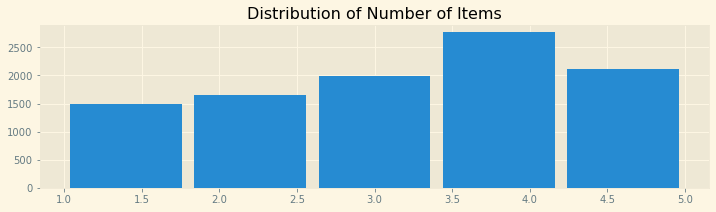

4    2764
5    2106
3    1996
2    1653
1    1497
Name: key, dtype: int64


In [5]:
fig = plt.figure(figsize = (12,3))
plt.hist(timeseries_df.key, rwidth = 0.9, bins = len(timeseries_df.key.unique()))
plt.title('Distribution of Number of Items')
plt.show()
print(timeseries_df.key.value_counts())

In [6]:
# удаление строк из df с самыми ранними продажами магаинов (не считаем первые 14 дней).
timeseries_df.sort_values(by=['key','ds'], axis=0, inplace=True)
timeseries_df['days_in_sales'] = timeseries_df.groupby('key').cumcount()
timeseries_df.drop(timeseries_df[timeseries_df.days_in_sales < 14].index, inplace=True)
timeseries_df['days_in_sales'] = timeseries_df.groupby('key').cumcount()

In [7]:
timeseries_df.sort_values(by=['key','ds'], inplace=True)

timeseries_df = (timeseries_df.groupby(['key'])
                 .apply(lambda x: x.set_index('ds').resample('D').ffill()))
timeseries_df = timeseries_df.reset_index(level=0, drop=True).reset_index()
timeseries_df

ds  key     y  ddd  days_in_sales
0     2019-06-24    1  1214  175              0
1     2019-06-25    1  1065  176              1
2     2019-06-26    1  1184  177              2
3     2019-06-27    1  1162  178              3
4     2019-06-28    1  1273  179              4
...          ...  ...   ...  ...            ...
10080 2023-07-27    5   982  208           2087
10081 2023-07-28    5   949  209           2088
10082 2023-07-29    5   941  210           2089
10083 2023-07-30    5   996  211           2090
10084 2023-07-31    5   932  212           2091

[10085 rows x 5 columns]

In [8]:
# Добавление аномальных периодов.
from datetime import datetime as dt

def anomal_periods(timeseries_df):
    if (timeseries_df['ds'] >= dt.strptime('2020-03-15', "%Y-%m-%d")) & (
        timeseries_df['ds'] < dt.strptime('2020-07-31', "%Y-%m-%d")):
        return 'COVID-19'
    elif (timeseries_df['ds'] >= dt.strptime('2021-06-12', "%Y-%m-%d")) & (
        timeseries_df['ds'] < dt.strptime('2021-07-31', "%Y-%m-%d")):
        return 'QR-codes'
    elif (timeseries_df['ds'] >= dt.strptime('2021-10-26', "%Y-%m-%d")) & (
        timeseries_df['ds'] < dt.strptime('2021-11-12', "%Y-%m-%d")):
        return 'lockdown'
    else:
        return 'None'

timeseries_df['anomal_periods'] = timeseries_df.apply(anomal_periods, axis=1)

In [9]:
# Приравниваем к 0 продажи в периоды аномальных дней.
def conditions(timeseries_df):
    if timeseries_df['anomal_periods'] == 'None':
        return timeseries_df['y']
    else:
        return 0

timeseries_df['y'] = timeseries_df.apply(lambda x: conditions(x), axis=1)
timeseries_df

ds  key     y  ddd  days_in_sales anomal_periods
0     2019-06-24    1  1214  175              0           None
1     2019-06-25    1  1065  176              1           None
2     2019-06-26    1  1184  177              2           None
3     2019-06-27    1  1162  178              3           None
4     2019-06-28    1  1273  179              4           None
...          ...  ...   ...  ...            ...            ...
10080 2023-07-27    5   982  208           2087           None
10081 2023-07-28    5   949  209           2088           None
10082 2023-07-29    5   941  210           2089           None
10083 2023-07-30    5   996  211           2090           None
10084 2023-07-31    5   932  212           2091           None

[10085 rows x 6 columns]

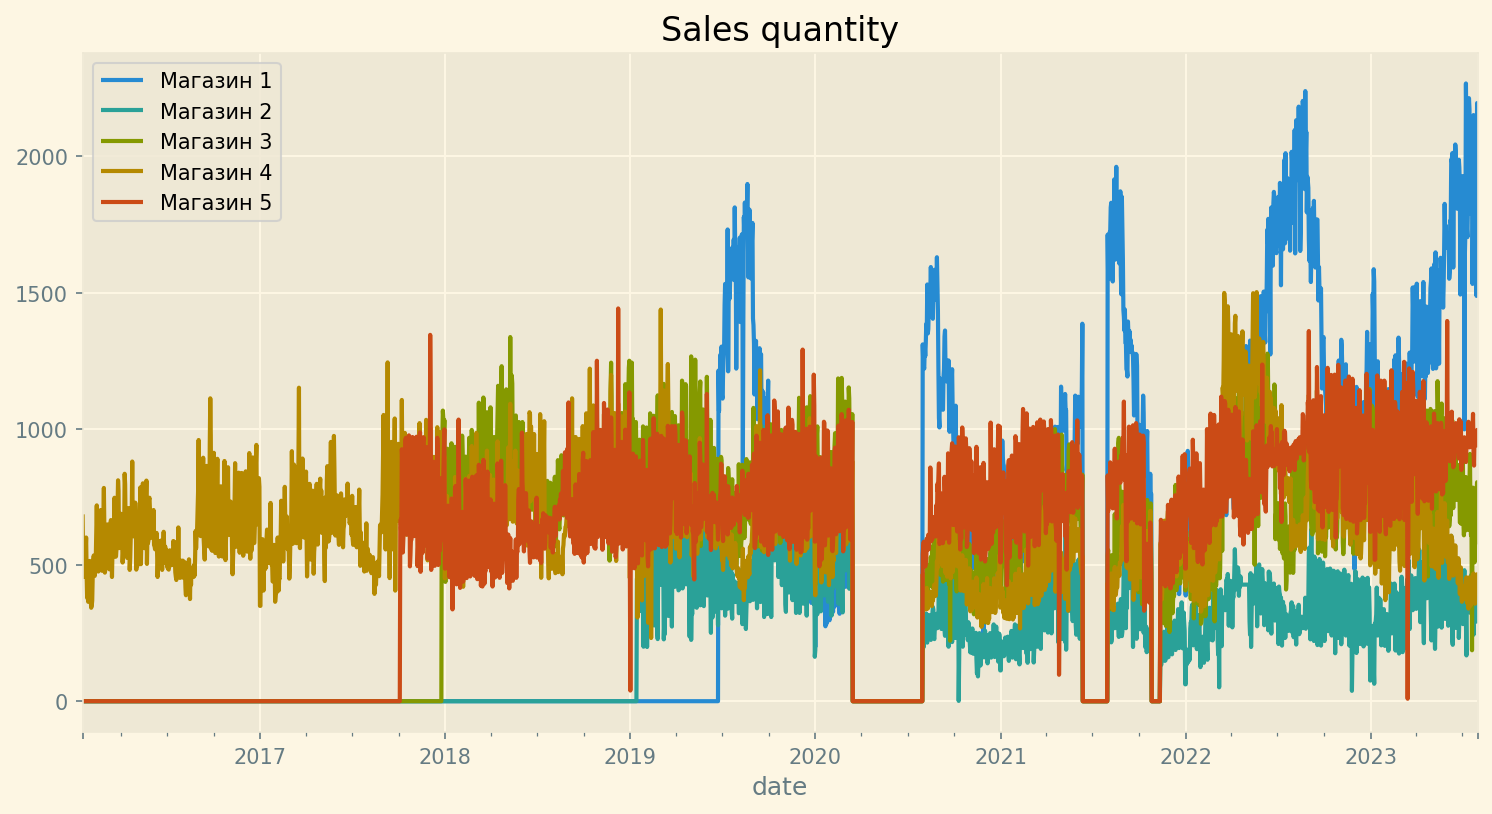

In [128]:
timeseries = timeseries_df[['ds','key','y']]
timeseries_1 = timeseries.pivot_table('y', ['ds'], 'key').fillna(0)

plt.figure(figsize=(12, 6), dpi=150)

timeseries_1.iloc[:,0].plot(label = 'Магазин 1')
timeseries_1.iloc[:,1].plot(label = 'Магазин 2')
timeseries_1.iloc[:,2].plot(label = 'Магазин 3')
timeseries_1.iloc[:,3].plot(label = 'Магазин 4')
timeseries_1.iloc[:,4].plot(label = 'Магазин 5')

plt.title('Sales quantity')
plt.xlabel('date')
plt.legend(loc='upper left')

In [11]:
# замена строк с аномальными периодами (0 продажи) на значения (pchip - monotonic cubic splines to find value of new points).

from scipy.interpolate import pchip

y = np.array(timeseries_df['y'])
x = np.arange(len(y))
idx = np.where(y!=0)
f = pchip(x[idx],y[idx])

y_interp = pd.DataFrame(f(x), columns=['y_interp1'])

timeseries_df = timeseries_df.merge(y_interp, left_index=True, right_index=True, how = 'left')

timeseries_df

ds  key     y  ddd  days_in_sales anomal_periods  y_interp1
0     2019-06-24    1  1214  175              0           None     1214.0
1     2019-06-25    1  1065  176              1           None     1065.0
2     2019-06-26    1  1184  177              2           None     1184.0
3     2019-06-27    1  1162  178              3           None     1162.0
4     2019-06-28    1  1273  179              4           None     1273.0
...          ...  ...   ...  ...            ...            ...        ...
10080 2023-07-27    5   982  208           2087           None      982.0
10081 2023-07-28    5   949  209           2088           None      949.0
10082 2023-07-29    5   941  210           2089           None      941.0
10083 2023-07-30    5   996  211           2090           None      996.0
10084 2023-07-31    5   932  212           2091           None      932.0

[10085 rows x 7 columns]

In [12]:
timeseries_df['y_interp1'].isnull().value_counts()

False    10085
Name: y_interp1, dtype: int64

In [13]:
#timeseries.to_excel(r"C:\Users\vadim.sokolov\Desktop\В\test5\!.timeseries_df.xlsx")

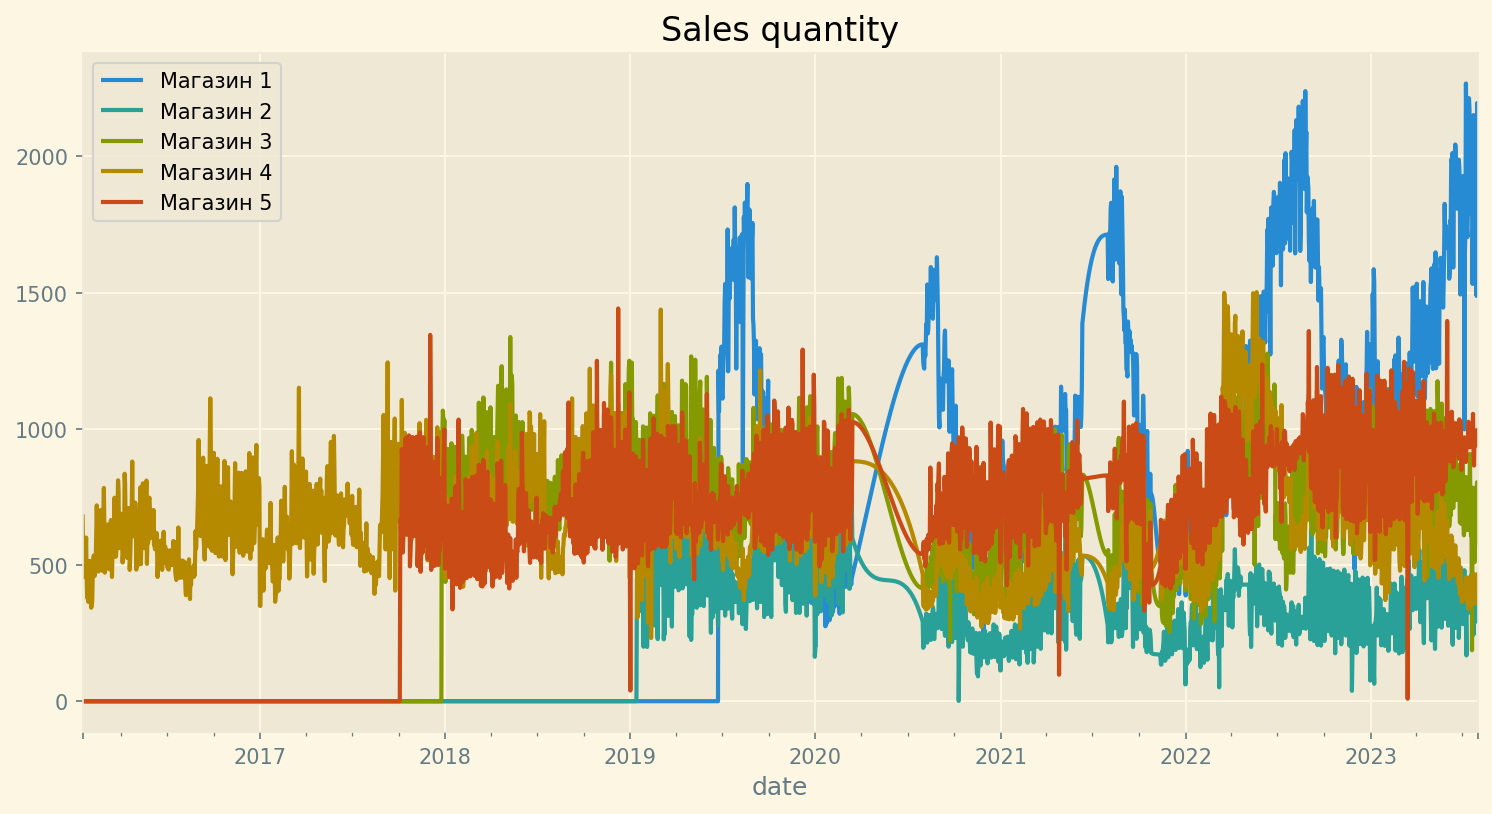

In [129]:
timeseries = timeseries_df.query('key!=0')[['ds','key','y_interp1']]
timeseries_1 = timeseries.pivot_table('y_interp1', ['ds'], 'key').fillna(0)

plt.figure(figsize=(12, 6), dpi=150)

timeseries_1.iloc[:,0].plot(label = 'Магазин 1')
timeseries_1.iloc[:,1].plot(label = 'Магазин 2')
timeseries_1.iloc[:,2].plot(label = 'Магазин 3')
timeseries_1.iloc[:,3].plot(label = 'Магазин 4')
timeseries_1.iloc[:,4].plot(label = 'Магазин 5')

plt.title('Sales quantity')
plt.xlabel('date')
plt.legend(loc='upper left')

In [15]:
# Заменяем сыбросы на значения скользящего среднего (не считая нулевые значения)
#timeseries_df['rollmean']  = timeseries_df['y'].rolling(200,min_periods=1).apply(lambda x: x[x!= 0].mean())

#def conditions(timeseries_df):
#    if timeseries_df['y']  == 0:
#        return timeseries_df['rollmean']
#    else:
#        return timeseries_df['y']
#
#timeseries_df['y'] = timeseries_df.apply(lambda x: conditions(x), axis=1)
#

In [16]:
timeseries = timeseries_df.set_index('ds')

### Time Series Decomposition

<Figure size 432x288 with 0 Axes>

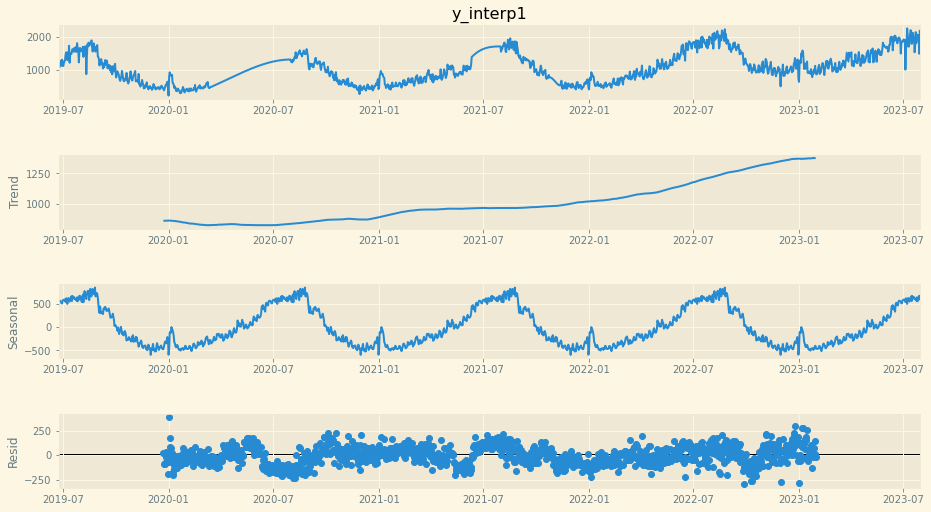

In [17]:
# Yearly trend/seasonality/residuals

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(timeseries.query('key==1')['y_interp1'], model = 'additive', period = 365) # выбрать магазин
                                                                                                       #- key==?
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(15,8)

<Figure size 432x288 with 0 Axes>

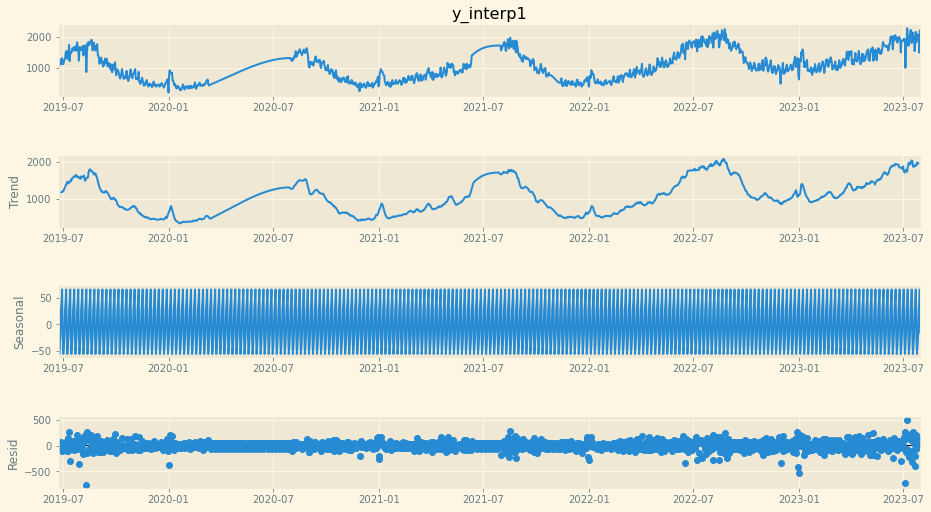

In [18]:
# Weekly trend/seasonality/residuals

decomp = seasonal_decompose(timeseries.query('key==1')['y_interp1'], model = 'additive', period = 7)

fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(15,8)

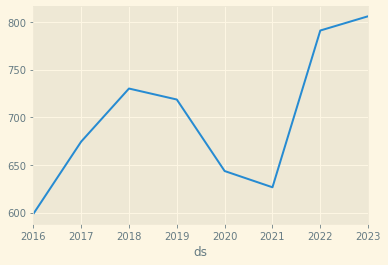

In [19]:
# тренд для всех магазинов суммарно.
week_timeseries = timeseries.query('key!=0')['y_interp1'].resample('W').mean()
year_timeseries = timeseries.query('key!=0')['y_interp1'].resample('Y').mean()

components_week = sm.tsa.seasonal_decompose(week_timeseries, model = 'additive')
components_year = sm.tsa.seasonal_decompose(year_timeseries, model = 'additive')

# тренд  
#components_week.trend.plot()
components_year.trend.plot()
plt.show()

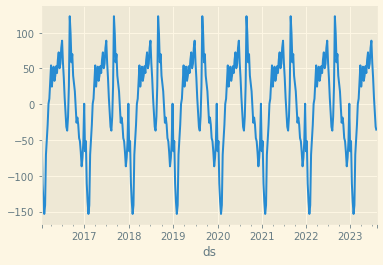

In [20]:
# сезонность 
components_week.seasonal.plot()

#residuals
#components_week.resid.plot()
plt.show()

In [22]:
# Определяем residuals в разрезе недели и года для дальнейшего выявления outliers.
segments = set(timeseries['key'])
data = pd.DataFrame([])
for s in segments:
    df = timeseries[timeseries['key'] == s]#.set_index('day_id') #.resample('H').mean()
    decomp_w = sm.tsa.seasonal_decompose(x=df['y_interp1'], model = 'additive', period = 52)
    decomp_y = sm.tsa.seasonal_decompose(x=df['y_interp1'], model = 'additive', period = 365)
    df = df.join(decomp_w.resid, how='left', lsuffix='_left', rsuffix='_right').join(decomp_y.resid, how='left', lsuffix='_left', rsuffix='_right')    #df.join(decomp.trend).join(decomp.seasonal).join(decomp.resid)
    
    df = df.rename(columns={'resid_left': 'resid_w', 'resid_right': 'resid_y'})

#optional columns with some statistics to find outliers and trend changes https://stackoverflow.com/questions/66911655/is-it-possible-to-apply-seasonal-decompose-after-a-groupby-where-date-is-not
    #df['resid_zscore_week'] = (df['resid_w'] - df['resid_w'].mean()).div(df['resid_w'].std())
    #df['resid_zscore_year'] = (df['resid_y'] - df['resid_y'].mean()).div(df['resid_y'].std())
    #df['trend_change'] = df.trend.pct_change()
    #df['trend_change_zscore'] = (df['trend_change'] - df['trend_change'].mean()).div(df['trend_change'].std())
    
    data = data.append(df)
data

key     y  ddd  days_in_sales anomal_periods  y_interp1  resid_w  \
ds                                                                             
2019-06-24    1  1214  175              0           None     1214.0      NaN   
2019-06-25    1  1065  176              1           None     1065.0      NaN   
2019-06-26    1  1184  177              2           None     1184.0      NaN   
2019-06-27    1  1162  178              3           None     1162.0      NaN   
2019-06-28    1  1273  179              4           None     1273.0      NaN   
...         ...   ...  ...            ...            ...        ...      ...   
2023-07-27    5   982  208           2087           None      982.0      NaN   
2023-07-28    5   949  209           2088           None      949.0      NaN   
2023-07-29    5   941  210           2089           None      941.0      NaN   
2023-07-30    5   996  211           2090           None      996.0      NaN   
2023-07-31    5   932  212           2091           None      932.0      NaN   

            resid_y  
ds                   
2019-06-24      NaN  
2019-06-25      NaN  
2019-06-26      NaN  
2019-06-27      NaN  
2019-06-28      NaN  
...             ...  
2023-07-27      NaN  
2023-07-28      NaN  
2023-07-29      NaN  
2023-07-30      NaN  
2023-07-31      NaN  

[10085 rows x 8 columns]

In [23]:
# Interquartile range method for week and year

segments = set(data['key'])
ts_df = pd.DataFrame([])
for s in segments:
    df = data[data['key'] == s]
    df['Q1_w'] = df['resid_w'].quantile(0.25)
    df['Q3_w'] = df['resid_w'].quantile(0.75)
    df['IQR_w'] = df['Q3_w'] - df['Q1_w']
    df['lower_w'] = df['Q1_w'] - 1.5 * df['IQR_w']
    df['upper_w'] = df['Q3_w'] + 1.5 * df['IQR_w']
    
    df['Q1_y'] = df['resid_y'].quantile(0.25)
    df['Q3_y'] = df['resid_y'].quantile(0.75)
    df['IQR_y'] = df['Q3_y'] - df['Q1_y']
    df['lower_y'] = df['Q1_y'] - 1.5 * df['IQR_y']
    df['upper_y'] = df['Q3_y'] + 1.5 * df['IQR_y']
    
    ts_df = ts_df.append(df)

ts_df.drop(['Q1_w','Q3_w','IQR_w','Q1_y','Q3_y','IQR_y'], axis=1, inplace=True)
ts_df.fillna(0,inplace=True)
ts_df

key     y  ddd  days_in_sales anomal_periods  y_interp1  resid_w  \
ds                                                                             
2019-06-24    1  1214  175              0           None     1214.0      0.0   
2019-06-25    1  1065  176              1           None     1065.0      0.0   
2019-06-26    1  1184  177              2           None     1184.0      0.0   
2019-06-27    1  1162  178              3           None     1162.0      0.0   
2019-06-28    1  1273  179              4           None     1273.0      0.0   
...         ...   ...  ...            ...            ...        ...      ...   
2023-07-27    5   982  208           2087           None      982.0      0.0   
2023-07-28    5   949  209           2088           None      949.0      0.0   
2023-07-29    5   941  210           2089           None      941.0      0.0   
2023-07-30    5   996  211           2090           None      996.0      0.0   
2023-07-31    5   932  212           2091           None      932.0      0.0   

            resid_y     lower_w     upper_w     lower_y     upper_y  
ds                                                                   
2019-06-24      0.0 -295.906681  286.708357 -273.704130  264.614966  
2019-06-25      0.0 -295.906681  286.708357 -273.704130  264.614966  
2019-06-26      0.0 -295.906681  286.708357 -273.704130  264.614966  
2019-06-27      0.0 -295.906681  286.708357 -273.704130  264.614966  
2019-06-28      0.0 -295.906681  286.708357 -273.704130  264.614966  
...             ...         ...         ...         ...         ...  
2023-07-27      0.0 -362.125608  340.160202 -370.450445  367.534922  
2023-07-28      0.0 -362.125608  340.160202 -370.450445  367.534922  
2023-07-29      0.0 -362.125608  340.160202 -370.450445  367.534922  
2023-07-30      0.0 -362.125608  340.160202 -370.450445  367.534922  
2023-07-31      0.0 -362.125608  340.160202 -370.450445  367.534922  

[10085 rows x 12 columns]

In [24]:
# ВАРИАНТ 1 RESID_ZSCORE > 2 *FILTER
#def conditions(ts_df):
#    if (abs(ts_df['resid_zscore']) > 2): # or (abs(data['trend_change_zscore']) > 3):
#        return 0
#    else:
#        return ts_df['y']
#    
#ts_df['y_outl'] = ts_df.apply(lambda x: conditions(x), axis=1)

In [25]:
# приравниваем к 0 продажи в те дни, где есть outliers.

ts_df['y_interp2'] = np.where((ts_df['resid_w'] > ts_df['lower_w']) & (
    ts_df['resid_w'] < ts_df['upper_w']), ts_df['y_interp1'], 0)

ts_df['y_interp2'] = np.where((ts_df['resid_y'] > ts_df['lower_y']) & (
    ts_df['resid_y'] < ts_df['upper_y']), ts_df['y_interp1'], 0)

ts_df.sort_values(by=['key','ds'], inplace=True)

#def conditions(ts_df):
#    if (ts_df['days_in_sales'] < 30) or (
#        ts_df['resid'] < ts_df['lower']) or (
#        ts_df['resid'] > ts_df['upper']):
#        return 0
#    else:
#        return ts_df['y_interp1']
#
#ts_df['y_interp2'] = ts_df.apply(lambda x: conditions(x), axis=1)

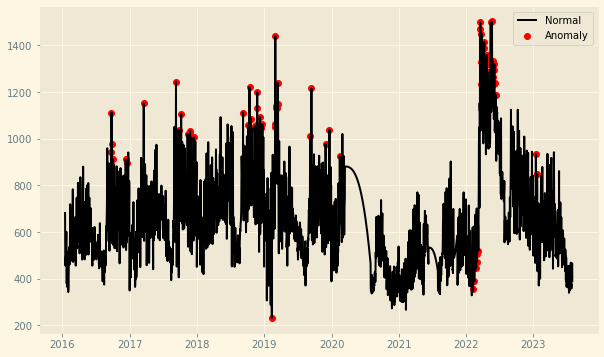

In [26]:
# визуализация магазинов с аномальными выбросами.
fig, ax = plt.subplots(figsize=(10,6))
data_scale = ts_df.query('key==4')[['y_interp1','y_interp2']]
a = data_scale.loc[data_scale['y_interp2'] == 0, ['y_interp1']] #anomaly
ax.plot(data_scale.index, data_scale['y_interp1'], color='black', label = 'Normal')
ax.scatter(a.index, a['y_interp1'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

In [27]:
ts_df['y_interp2'].sum()/ts_df['y_interp1'].sum()-1

-0.01898538306739861

In [28]:
# замена строк с outliers (0 продажи) на значения (monotonic cubic splines to find the value of new points)
y = np.array(ts_df['y_interp2'])
x = np.arange(len(y))
idx = np.where(y!=0)
f = pchip(x[idx],y[idx])

y_interp3 = pd.DataFrame(f(x), columns=['y_interp3'])

ts_df = pd.merge(ts_df.reset_index(), y_interp3, left_index=True, right_index=True, how = 'left')
ts_df

ds  key     y  ddd  days_in_sales anomal_periods  y_interp1  \
0     2019-06-24    1  1214  175              0           None     1214.0   
1     2019-06-25    1  1065  176              1           None     1065.0   
2     2019-06-26    1  1184  177              2           None     1184.0   
3     2019-06-27    1  1162  178              3           None     1162.0   
4     2019-06-28    1  1273  179              4           None     1273.0   
...          ...  ...   ...  ...            ...            ...        ...   
10080 2023-07-27    5   982  208           2087           None      982.0   
10081 2023-07-28    5   949  209           2088           None      949.0   
10082 2023-07-29    5   941  210           2089           None      941.0   
10083 2023-07-30    5   996  211           2090           None      996.0   
10084 2023-07-31    5   932  212           2091           None      932.0   

       resid_w  resid_y     lower_w     upper_w     lower_y     upper_y  \
0          0.0      0.0 -295.906681  286.708357 -273.704130  264.614966   
1          0.0      0.0 -295.906681  286.708357 -273.704130  264.614966   
2          0.0      0.0 -295.906681  286.708357 -273.704130  264.614966   
3          0.0      0.0 -295.906681  286.708357 -273.704130  264.614966   
4          0.0      0.0 -295.906681  286.708357 -273.704130  264.614966   
...        ...      ...         ...         ...         ...         ...   
10080      0.0      0.0 -362.125608  340.160202 -370.450445  367.534922   
10081      0.0      0.0 -362.125608  340.160202 -370.450445  367.534922   
10082      0.0      0.0 -362.125608  340.160202 -370.450445  367.534922   
10083      0.0      0.0 -362.125608  340.160202 -370.450445  367.534922   
10084      0.0      0.0 -362.125608  340.160202 -370.450445  367.534922   

       y_interp2  y_interp3  
0         1214.0     1214.0  
1         1065.0     1065.0  
2         1184.0     1184.0  
3         1162.0     1162.0  
4         1273.0     1273.0  
...          ...        ...  
10080      982.0      982.0  
10081      949.0      949.0  
10082      941.0      941.0  
10083      996.0      996.0  
10084      932.0      932.0  

[10085 rows x 15 columns]

In [29]:
ts_df[ts_df['y_interp3'] == 0]

Empty DataFrame
Columns: [ds, key, y, ddd, days_in_sales, anomal_periods, y_interp1, resid_w, resid_y, lower_w, upper_w, lower_y, upper_y, y_interp2, y_interp3]
Index: []

<AxesSubplot:>

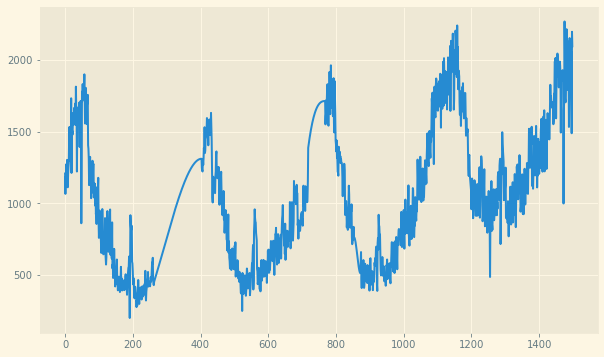

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
data_scale = ts_df.query('key==1')['y_interp3']
data_scale.plot()                          

In [31]:
ts_df.drop(['anomal_periods','y_interp1','resid_w','resid_y','lower_w','upper_w','y_interp2'], axis=1, inplace=True)

In [32]:
ts_df['y'].isnull().value_counts()

False    10085
Name: y, dtype: int64

In [33]:
df2 = pd.merge(ts_df, calendar_df, left_on='ds', right_on='day_id', how='left')
df2.sort_values(by=['key','day_id'], inplace=True)
df2.drop(['ds'], axis=1, inplace=True)
df2

key     y  ddd  days_in_sales     lower_y     upper_y  y_interp3  \
0        1  1214  175              0 -273.704130  264.614966     1214.0   
1        1  1065  176              1 -273.704130  264.614966     1065.0   
2        1  1184  177              2 -273.704130  264.614966     1184.0   
3        1  1162  178              3 -273.704130  264.614966     1162.0   
4        1  1273  179              4 -273.704130  264.614966     1273.0   
...    ...   ...  ...            ...         ...         ...        ...   
10080    5   982  208           2087 -370.450445  367.534922      982.0   
10081    5   949  209           2088 -370.450445  367.534922      949.0   
10082    5   941  210           2089 -370.450445  367.534922      941.0   
10083    5   996  211           2090 -370.450445  367.534922      996.0   
10084    5   932  212           2091 -370.450445  367.534922      932.0   

          day_id  week_id  month_id  year_id  day_year  day_week  day_number  \
0     2019-06-24   201926    201906     2019       175         1          24   
1     2019-06-25   201926    201906     2019       176         2          25   
2     2019-06-26   201926    201906     2019       177         3          26   
3     2019-06-27   201926    201906     2019       178         4          27   
4     2019-06-28   201926    201906     2019       179         5          28   
...          ...      ...       ...      ...       ...       ...         ...   
10080 2023-07-27   202330    202307     2023       208         4          27   
10081 2023-07-28   202330    202307     2023       209         5          28   
10082 2023-07-29   202330    202307     2023       210         6          29   
10083 2023-07-30   202330    202307     2023       211         7          30   
10084 2023-07-31   202331    202307     2023       212         1          31   

       week_number  month_number  quarter_number  is_holiday  is_warm  \
0               26             6               2           0        1   
1               26             6               2           0        1   
2               26             6               2           0        1   
3               26             6               2           0        1   
4               26             6               2           0        1   
...            ...           ...             ...         ...      ...   
10080           30             7               3           0        1   
10081           30             7               3           0        1   
10082           30             7               3           0        1   
10083           30             7               3           0        1   
10084           31             7               3           0        1   

       is_black_friday  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
10080                0  
10081                0  
10082                0  
10083                0  
10084                0  

[10085 rows x 20 columns]

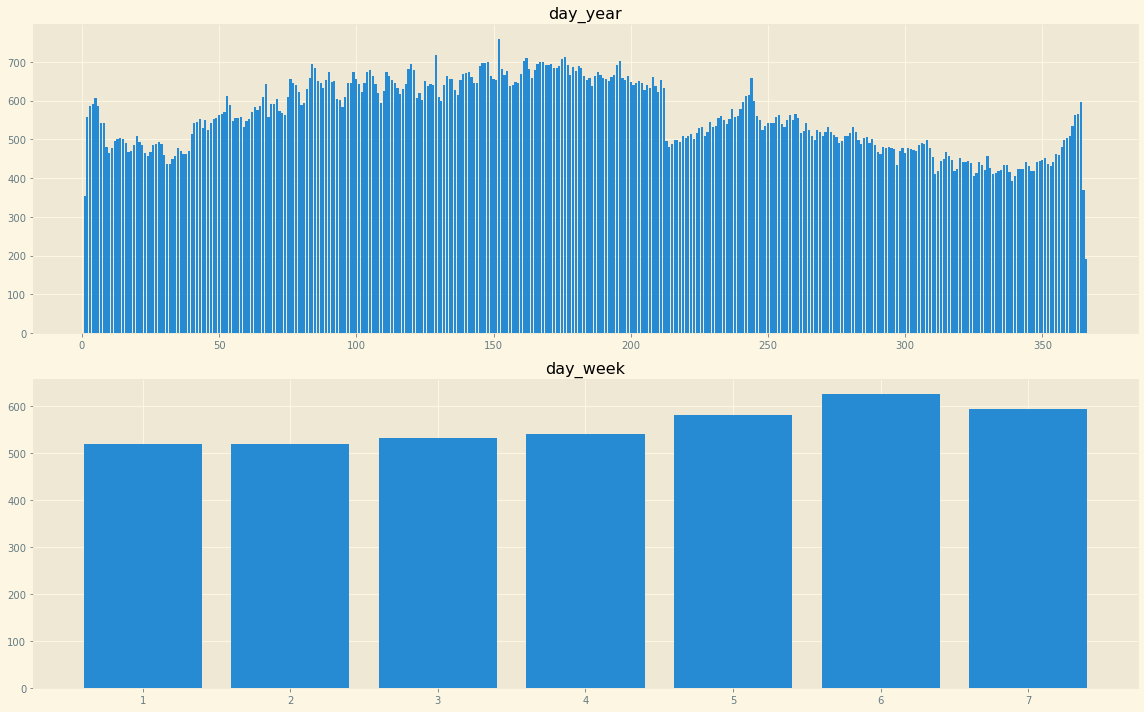

In [131]:
# сезонность внутри года, недели

nrows, ncols = 2,1 
fig, ax = plt.subplots(nrows, ncols, figsize=(16,10))

for i, col in enumerate(['day_year','day_week']): 
    plot_data = df2.query('key!=0').groupby(col)['y_interp3'].mean()
    
    cax = plt.subplot(nrows, ncols, i+1)
    cax.bar(plot_data.index, plot_data.values)
    # Need to add automatic adding of labels of x-axis
    cax.set_title('{}'.format(col, fontsize=10))

plt.tight_layout()
plt.show()

pd.options.mode.chained_assignment = 'warn'

In [34]:
# Создание тестового df для построения прогноза с 31.07.2023.

test1 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
test2 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
test3 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
test4 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
test5 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()

test1['key'] = 1
test2['key'] = 2
test3['key'] = 3
test4['key'] = 4
test5['key'] = 5

df = pd.concat([df2, test1, test2, test3, test4, test5], ignore_index=True)

In [35]:
def create_date_featues(df):
    df['is_wknd'] = df.day_id.dt.weekday//4
    df['is_month_start'] = df.day_id.dt.is_month_start.astype(int)
    df['is_month_end'] = df.day_id.dt.is_month_end.astype(int)
    return df

In [36]:
df = create_date_featues(df)
df.sort_values(by=['key','day_id'], axis=0, inplace=True)
df.head()

key       y    ddd  days_in_sales    lower_y     upper_y  y_interp3  \
0    1  1214.0  175.0            0.0 -273.70413  264.614966     1214.0   
1    1  1065.0  176.0            1.0 -273.70413  264.614966     1065.0   
2    1  1184.0  177.0            2.0 -273.70413  264.614966     1184.0   
3    1  1162.0  178.0            3.0 -273.70413  264.614966     1162.0   
4    1  1273.0  179.0            4.0 -273.70413  264.614966     1273.0   

      day_id  week_id  month_id  ...  day_number  week_number  month_number  \
0 2019-06-24   201926    201906  ...          24           26             6   
1 2019-06-25   201926    201906  ...          25           26             6   
2 2019-06-26   201926    201906  ...          26           26             6   
3 2019-06-27   201926    201906  ...          27           26             6   
4 2019-06-28   201926    201906  ...          28           26             6   

   quarter_number  is_holiday  is_warm  is_black_friday  is_wknd  \
0               2           0        1                0        0   
1               2           0        1                0        0   
2               2           0        1                0        0   
3               2           0        1                0        0   
4               2           0        1                0        1   

   is_month_start  is_month_end  
0               0             0  
1               0             0  
2               0             0  
3               0             0  
4               0             0  

[5 rows x 23 columns]

## Random Noise

In [37]:
def random_noise(df):
    return np.random.normal(size = (len(df),))

## Lag/Shifted features

In [38]:
def lag_features(df, lags):
    df = df.copy()
    for lag in lags:
        df['sales_lag' + str(lag)] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(lag)) + random_noise(df)
    return df

In [39]:
df = lag_features(df, [91,98,105,112,119,126,182,364,365,546,728])

## Rolling mean / Moving Average

In [40]:
def roll_mean_features(df, windows):
    df = df.copy()
    for window in windows:
        df['sales_roll_mean' + str(window)] = df.groupby(['key'])['y_interp3'].transform(
            lambda x: x.shift(1).rolling(window = window, min_periods = 10, win_type = 'triang').mean()) + random_noise(df)
    return df

In [41]:
df = roll_mean_features(df, [91,98,105,112,119,126,182,364,365,546,728])
df.head()

key       y    ddd  days_in_sales    lower_y     upper_y  y_interp3  \
0    1  1214.0  175.0            0.0 -273.70413  264.614966     1214.0   
1    1  1065.0  176.0            1.0 -273.70413  264.614966     1065.0   
2    1  1184.0  177.0            2.0 -273.70413  264.614966     1184.0   
3    1  1162.0  178.0            3.0 -273.70413  264.614966     1162.0   
4    1  1273.0  179.0            4.0 -273.70413  264.614966     1273.0   

      day_id  week_id  month_id  ...  sales_roll_mean98  sales_roll_mean105  \
0 2019-06-24   201926    201906  ...                NaN                 NaN   
1 2019-06-25   201926    201906  ...                NaN                 NaN   
2 2019-06-26   201926    201906  ...                NaN                 NaN   
3 2019-06-27   201926    201906  ...                NaN                 NaN   
4 2019-06-28   201926    201906  ...                NaN                 NaN   

   sales_roll_mean112  sales_roll_mean119  sales_roll_mean126  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   sales_roll_mean182  sales_roll_mean364  sales_roll_mean365  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   sales_roll_mean546  sales_roll_mean728  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 45 columns]

## Exponentially Weighted Mean features|

In [42]:
def ewm_features(df, alphas, lags):
    df = df.copy()
    for alpha in alphas:
        for lag in lags:
            df['sales_ewm_alpha_' + str(alpha).replace('.','') + '_lag_' + str(lag)] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return df

In [43]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,98,105,112,180,270,364,365,546,728]

In [44]:
df = ewm_features(df, alphas, lags)
df.tail()

key   y  ddd  days_in_sales  lower_y  upper_y  y_interp3     day_id  \
12675    5 NaN  NaN            NaN      NaN      NaN        NaN 2024-12-27   
12676    5 NaN  NaN            NaN      NaN      NaN        NaN 2024-12-28   
12677    5 NaN  NaN            NaN      NaN      NaN        NaN 2024-12-29   
12678    5 NaN  NaN            NaN      NaN      NaN        NaN 2024-12-30   
12679    5 NaN  NaN            NaN      NaN      NaN        NaN 2024-12-31   

       week_id  month_id  ...  sales_ewm_alpha_05_lag_91  \
12675   202452    202412  ...                 952.659937   
12676   202452    202412  ...                 952.659937   
12677   202452    202412  ...                 952.659937   
12678   202501    202412  ...                 952.659937   
12679   202501    202412  ...                 952.659937   

       sales_ewm_alpha_05_lag_98  sales_ewm_alpha_05_lag_105  \
12675                 952.659937                  952.659937   
12676                 952.659937                  952.659937   
12677                 952.659937                  952.659937   
12678                 952.659937                  952.659937   
12679                 952.659937                  952.659937   

       sales_ewm_alpha_05_lag_112  sales_ewm_alpha_05_lag_180  \
12675                  952.659937                  952.659937   
12676                  952.659937                  952.659937   
12677                  952.659937                  952.659937   
12678                  952.659937                  952.659937   
12679                  952.659937                  952.659937   

       sales_ewm_alpha_05_lag_270  sales_ewm_alpha_05_lag_364  \
12675                  952.659937                  952.659937   
12676                  952.659937                  952.659937   
12677                  952.659937                  952.659937   
12678                  952.659937                  952.659937   
12679                  952.659937                  952.659937   

       sales_ewm_alpha_05_lag_365  sales_ewm_alpha_05_lag_546  \
12675                  952.659937                  918.886390   
12676                  952.659937                  935.443195   
12677                  952.659937                  913.721597   
12678                  952.659937                  925.360799   
12679                  952.659937                  908.680399   

       sales_ewm_alpha_05_lag_728  
12675                 1083.122981  
12676                  852.561490  
12677                  737.280745  
12678                  802.140373  
12679                  850.570186  

[5 rows x 95 columns]

In [45]:
# Rollings with sliding shift
for w_shift in [1,2,3,7]: 
    print('Shifting period:', w_shift)
    for w_window in [91,98,105,112,119,126,182,364,365,546,730]:
        #col_name1 = 'f_rolling_mean_'+str(w_shift)+'_'+str(w_window)
        col_name2 = 'f_rolling_median_'+str(w_shift)+'_'+str(w_window)
        col_name3 = 'f_rolling_min_'+str(w_shift)+'_'+str(w_window)
        col_name4 = 'f_rolling_max_'+str(w_shift)+'_'+str(w_window)
        col_name5 = 'f_rolling_std_'+str(w_shift)+'_'+str(w_window)
        
        #df[col_name1] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(w_shift).rolling(w_window).
        #                                                     mean()).astype(np.float16)
        df[col_name2] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(w_shift).rolling(w_window).
                                                             median()).astype(np.float16)
        df[col_name3] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(w_shift).rolling(w_window).
                                                             min()).astype(np.float16)
        df[col_name4] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(w_shift).rolling(w_window).
                                                             max()).astype(np.float16)            
        df[col_name5] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(w_shift).rolling(w_window).
                                                             std()).astype(np.float16)             
        
df = df.fillna(0)
df

Shifting period: 1
Shifting period: 2
Shifting period: 3
Shifting period: 7


key       y    ddd  days_in_sales    lower_y     upper_y  y_interp3  \
0        1  1214.0  175.0            0.0 -273.70413  264.614966     1214.0   
1        1  1065.0  176.0            1.0 -273.70413  264.614966     1065.0   
2        1  1184.0  177.0            2.0 -273.70413  264.614966     1184.0   
3        1  1162.0  178.0            3.0 -273.70413  264.614966     1162.0   
4        1  1273.0  179.0            4.0 -273.70413  264.614966     1273.0   
...    ...     ...    ...            ...        ...         ...        ...   
12675    5     0.0    0.0            0.0    0.00000    0.000000        0.0   
12676    5     0.0    0.0            0.0    0.00000    0.000000        0.0   
12677    5     0.0    0.0            0.0    0.00000    0.000000        0.0   
12678    5     0.0    0.0            0.0    0.00000    0.000000        0.0   
12679    5     0.0    0.0            0.0    0.00000    0.000000        0.0   

          day_id  week_id  month_id  ...  f_rolling_max_7_365  \
0     2019-06-24   201926    201906  ...                  0.0   
1     2019-06-25   201926    201906  ...                  0.0   
2     2019-06-26   201926    201906  ...                  0.0   
3     2019-06-27   201926    201906  ...                  0.0   
4     2019-06-28   201926    201906  ...                  0.0   
...          ...      ...       ...  ...                  ...   
12675 2024-12-27   202452    202412  ...                  0.0   
12676 2024-12-28   202452    202412  ...                  0.0   
12677 2024-12-29   202452    202412  ...                  0.0   
12678 2024-12-30   202501    202412  ...                  0.0   
12679 2024-12-31   202501    202412  ...                  0.0   

       f_rolling_std_7_365  f_rolling_median_7_546  f_rolling_min_7_546  \
0                      0.0                     0.0                  0.0   
1                      0.0                     0.0                  0.0   
2                      0.0                     0.0                  0.0   
3                      0.0                     0.0                  0.0   
4                      0.0                     0.0                  0.0   
...                    ...                     ...                  ...   
12675                  0.0                     0.0                  0.0   
12676                  0.0                     0.0                  0.0   
12677                  0.0                     0.0                  0.0   
12678                  0.0                     0.0                  0.0   
12679                  0.0                     0.0                  0.0   

       f_rolling_max_7_546  f_rolling_std_7_546  f_rolling_median_7_730  \
0                      0.0                  0.0                     0.0   
1                      0.0                  0.0                     0.0   
2                      0.0                  0.0                     0.0   
3                      0.0                  0.0                     0.0   
4                      0.0                  0.0                     0.0   
...                    ...                  ...                     ...   
12675                  0.0                  0.0                     0.0   
12676                  0.0                  0.0                     0.0   
12677                  0.0                  0.0                     0.0   
12678                  0.0                  0.0                     0.0   
12679                  0.0                  0.0                     0.0   

       f_rolling_min_7_730  f_rolling_max_7_730  f_rolling_std_7_730  
0                      0.0                  0.0                  0.0  
1                      0.0                  0.0                  0.0  
2                      0.0                  0.0                  0.0  
3                      0.0                  0.0                  0.0  
4                      0.0                  0.0                  0.0  
...                    ...                  ...              

In [46]:
#https://www.kaggle.com/code/zhikchen/forecasting-prediction-using-lightgbm-model
#    Exponentially Weighted Rolling Mean
#We can apply a weight to our window feature so that more recent observations are more heavily weighted. This way our model is 
#more sensitive to recent observations and can pick up changes in trend.
#There are different ways to pick the weights of the observations. If we use a linear weight, the weights decay lineary 
#overtime. If we use an exponential weight, the weights decay exponentially over time so a lot more weight is allocated to 
#recent observations.
#Users specify a value of α. The equation for Exponentially Weight Moving Avereage (EWMA) is defined as:
#1∗yt+(1−α)∗yt−1+(1−α)2∗yt−2...+(1−α)W−1yt−W−11+(1−α)+(1−α)2+...+(1−α)W−1
#Picking value for α
#We can fit a Simple Exponential Smoothing Model and extract the learning parameter (α) of the fitted model

windows = [91,98,105,112,119,126,182,364,365,546,730]

ses = SimpleExpSmoothing(df.y_interp3).fit(optimized = True)
alpha = ses.params['smoothing_level']
print(alpha)

0.6646216784040622


In [47]:
#https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/#h-feature-engineering-for-time-series-1-date-related-features
#Feature Engineering for Time Series #5: Expanding Window Feature
#This is simply an advanced version of the rolling window technique. In the case of a rolling window, the size of the window 
#is constant while the window slides as we move forward in time. Hence, we consider only the most recent values and ignore 
#the past values.

#The idea behind the expanding window feature is that it takes all the past values into account.
#df['expanding_mean'] = df['y_interp3'].expanding(2).mean()

In [48]:
# Добавление аномальных периодов.
#from datetime import datetime as dt

#def anomal_periods(df):
#    if (df['day_id'] >= dt.strptime('2020-03-30', "%Y-%m-%d")) & (df['day_id'] < dt.strptime('2020-07-31', "%Y-%m-%d")):
#        return 'COVID-19'
#    elif (df['day_id'] >= dt.strptime('2021-06-12', "%Y-%m-%d")) & (df['day_id'] < dt.strptime('2021-07-31', "%Y-%m-%d")):
#        return 'QR-codes'
#    elif (df['day_id'] >= dt.strptime('2021-10-26', "%Y-%m-%d")) & (df['day_id'] < dt.strptime('2021-11-12', "%Y-%m-%d")):
#        return 'lockdown'
#    else:
#        return 'None'

#df['anomal_periods'] = df.apply(anomal_periods, axis=1)

In [49]:
# Поиск максимальных значений корреляции с сортировкой самых значимых. 
# Тут не требуется, т.к. все изначальные features - категориальные.

#correlations = df.corr()['y_interp3'].sort_values()

#print('Most Positive Correlations:\n', correlations.tail(10))
#print('\nMost Negative Correlations:\n', correlations.head(10))

In [50]:
# Ни один из числовых (не категориальных) столбцов не имеет значительную негативную корреляцию со столбцом 'y', 
# добавлять polinomial features в данном случае не требуется.

#features_with_negative_correlation = []

#ext_data = df[['y', features_with_negative_correlation]]

# Создание новой df с polynomial features
#poly_features_df = df[[features_with_negative_correlation, 'y']]
# SimpleImputer для обработки пропущенных значений.
#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

#poly_target = poly_features_df['y']
#poly_features_df = poly_features_df.drop(columns = ['y'])

# Добавление недостающих значений
#poly_features_df = imputer.fit_transform(poly_features_df)
#from sklearn.preprocessing import PolynomialFeatures

# Создание полиномиального объекта, возведение в степень.
#poly_transformer = PolynomialFeatures(degree = 2)

# Train polynomial features
#poly_transformer.fit(poly_features_df)

# Transform features
#poly_features_df = poly_transformer.transform(poly_features_df)
#print('Polynomial Features shape: ', poly_features_df.shape)

#poly_transformer.get_feature_names(input_features = [features_with_negative_correlation])

#poly_features_df = pd.DataFrame(poly_features_df, 
#                                   columns = poly_transformer.get_feature_names([features_with_negative_correlation]))
# Создание df с polynomial features.
#poly_features_df = pd.DataFrame(poly_features_df, 
#                                   columns = poly_transformer.get_feature_names([features_with_negative_correlation]))
# Добавление polnomial features в  dataframe.
#df_polynomial = df.merge(poly_features_df, how = 'left')

In [51]:
#scaler = StandardScaler()
#data_scale = pd.DataFrame(scaler.fit_transform(df['y_interp3'].array.reshape(-1, 1)),columns=['y_interp3'])
#data_scale = pd.DataFrame(data_scale.unstack(),columns=['y_sc']).dropna()
#df = pd.merge(df, data_scale.reset_index(drop=True), how='left', left_index=True, right_index=True)
#df

#df['y_interp3'] = np.log1p(df['y_interp3'].values)
#df

In [52]:
categories = ['key', 'ddd', 'week_id', 'month_id', 'year_id', 'day_year', 'day_id',
              'day_week', 'day_number', 'week_number', 'month_number',
              'quarter_number', 'is_holiday', 'is_warm', 'is_black_friday']

In [59]:
# список всех унакальных категориальных данных по столбцам.
categories_df = df[categories]

def find_unique(col):
    print(col,":",categories_df[col].unique())
for col in categories_df.columns:
    find_unique(col)
    
del categories_df

key : [1 2 3 4 5]
ddd : [175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188.
 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202.
 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216.
 217. 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230.
 231. 232. 233. 234. 235. 236. 237. 238. 239. 240. 241. 242. 243. 244.
 245. 246. 247. 248. 249. 250. 251. 252. 253. 254. 255. 256. 257. 258.
 259. 260. 261. 262. 263. 264. 265. 266. 267. 268. 269. 270. 271. 272.
 273. 274. 275. 276. 277. 278. 279. 280. 281. 282. 283. 284. 285. 286.
 287. 288. 289. 290. 291. 292. 293. 294. 295. 296. 297. 298. 299. 300.
 301. 302. 303. 304. 305. 306. 307. 308. 309. 310. 311. 312. 313. 314.
 315. 316. 317. 318. 319. 320. 321. 322. 323. 324. 325. 326. 327. 328.
 329. 330. 331. 332. 333. 334. 335. 336. 337. 338. 339. 340. 341. 342.
 343. 344. 345. 346. 347. 348. 349. 350. 351. 352. 353. 354. 355. 356.
 357. 358. 359. 360. 361. 362. 363. 364. 365.   1.   

In [60]:
df_train_test = df.loc[pd.to_datetime(df.day_id, format='%Y-%m-%d') <= pd.to_datetime('2023-07-31', format='%Y-%m-%d')].copy()
df_submission = df.loc[pd.to_datetime(df.day_id, format='%Y-%m-%d')  >  pd.to_datetime('2023-07-31', format='%Y-%m-%d')].copy()

df_train_test['day_id'] = pd.to_datetime(df_train_test['day_id']).dt.strftime('%Y%m%d')
df_submission['day_id'] = pd.to_datetime(df_submission['day_id']).dt.strftime('%Y%m%d')

df_train_test[categories] = df_train_test[categories].astype('category')
df_submission[categories] = df_submission[categories].astype('category')


X = df_train_test.drop(columns=['y','lower_y','upper_y','y_interp3'])
y = df_train_test['y_interp3']

df_submission.drop(columns=['y','lower_y','upper_y','y_interp3'],inplace=True)

In [61]:
list(X.columns)

['key',
 'ddd',
 'days_in_sales',
 'day_id',
 'week_id',
 'month_id',
 'year_id',
 'day_year',
 'day_week',
 'day_number',
 'week_number',
 'month_number',
 'quarter_number',
 'is_holiday',
 'is_warm',
 'is_black_friday',
 'is_wknd',
 'is_month_start',
 'is_month_end',
 'sales_lag91',
 'sales_lag98',
 'sales_lag105',
 'sales_lag112',
 'sales_lag119',
 'sales_lag126',
 'sales_lag182',
 'sales_lag364',
 'sales_lag365',
 'sales_lag546',
 'sales_lag728',
 'sales_roll_mean91',
 'sales_roll_mean98',
 'sales_roll_mean105',
 'sales_roll_mean112',
 'sales_roll_mean119',
 'sales_roll_mean126',
 'sales_roll_mean182',
 'sales_roll_mean364',
 'sales_roll_mean365',
 'sales_roll_mean546',
 'sales_roll_mean728',
 'sales_ewm_alpha_095_lag_91',
 'sales_ewm_alpha_095_lag_98',
 'sales_ewm_alpha_095_lag_105',
 'sales_ewm_alpha_095_lag_112',
 'sales_ewm_alpha_095_lag_180',
 'sales_ewm_alpha_095_lag_270',
 'sales_ewm_alpha_095_lag_364',
 'sales_ewm_alpha_095_lag_365',
 'sales_ewm_alpha_095_lag_546',
 'sales_

In [62]:
X.dtypes

key                       category
ddd                       category
days_in_sales              float64
day_id                    category
week_id                   category
                            ...   
f_rolling_median_7_730     float16
f_rolling_min_7_730        float16
f_rolling_max_7_730        float16
f_rolling_std_7_730        float16
expanding_mean             float64
Length: 268, dtype: object

In [63]:
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.25)#, random_state = 7)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(7563, 268) (7563,)
(2522, 268) (2522,)


### Подбор оптимальных параметров для модели с использованием Optuna

In [65]:
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor as LGBMR

def objective(trial, X, y):
    param_grid = {'verbosity': -1,
                  'boosting_type': 'gbdt',
                  'linear_tree': True,    # для учёта линейного тренда
                  'objective': 'regression',
                  'n_estimators': trial.suggest_categorical('n_estimators', [500]),
                  'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
                  'num_leaves': trial.suggest_int('num_leaves', 2, 2048, step=20),
                  'max_depth': trial.suggest_categorical("max_depth", [3,4,6,8,12,15]),
                  'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 1000, step=10),
                  'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
                  'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
                  'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
                  'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.95, step=0.1),
                  'bagging_freq': trial.suggest_categorical('bagging_freq', [1]),
                  'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1),
                  'feature_pre_filter': False,
                  'random_state': trial.suggest_categorical('random_state', [78]),
                  'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
                  #"device_type": trial.suggest_categorical("device_type", ['gpu']),
                  'categorical_feature': 'auto' # categories
                  }
    
    cv = KFold(n_splits=10, shuffle=True, random_state=78)
    cv_scores = np.empty(10)
    
    #for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    for idx, (trn_idx, test_idx) in enumerate(cv.split(X, y)):
        X_tr,X_val = X.iloc[trn_idx], X.iloc[test_idx]
        y_tr,y_val = y[trn_idx], y[test_idx]
        model = LGBMR( **param_grid)
        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val,y_val)],
            eval_metric='rmse',
            early_stopping_rounds=50,
            callbacks=[
                LightGBMPruningCallback(trial, 'rmse')  # Add a pruning callback
            ],
        )
        preds = model.predict(X_val)
        # Сохраняем в массив результаты проверки
        cv_scores[idx] = mean_squared_error(y_val, preds, squared=False)
        
    return np.mean(cv_scores)

# To this grid, I also added LightGBMPruningCallback from Optuna's integration module. This callback class is handy - it can 
# detect unpromising hyperparameter sets before training them on the data, reducing the search time significantly.
# You should pass it to LGBM’s fit method under callbacks and set the trial object and the evaluation metric you are using as
# parameters. Now, let’s create the study and run a few trials:

study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=200, timeout=2000)

print(f'\tBest value (rmse): {study.best_value:.5f}')
print(f'\tBest params:')

for key, value in study.best_params.items():
    print(f'\t\t{key}:{value}')

[I 2023-10-02 13:31:33,874] A new study created in memory with name: LGBM Regressor


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=530
[LightGBM] [Warning] min_gain_to_split is set=13.297979356866877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.297979356866877
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5

[I 2023-10-02 13:31:48,467] Trial 0 finished with value: 93.30143680308358 and parameters: {'n_estimators': 500, 'learning_rate': 0.06243094646940357, 'num_leaves': 422, 'max_depth': 4, 'min_data_in_leaf': 530, 'lambda_l1': 45, 'lambda_l2': 25, 'min_gain_to_split': 13.297979356866877, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': True}. Best is trial 0 with value: 93.30143680308358.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=460
[LightGBM] [Warning] min_gain_to_split is set=4.575468878521694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.575468878521694
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=460

[I 2023-10-02 13:32:13,759] Trial 1 finished with value: 97.03674108698887 and parameters: {'n_estimators': 500, 'learning_rate': 0.0834767138851015, 'num_leaves': 1542, 'max_depth': 15, 'min_data_in_leaf': 460, 'lambda_l1': 30, 'lambda_l2': 20, 'min_gain_to_split': 4.575468878521694, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': False}. Best is trial 0 with value: 93.30143680308358.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=710
[LightGBM] [Warning] min_gain_to_split is set=5.0366467178532535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0366467178532535
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warn

[I 2023-10-02 13:32:32,127] Trial 2 finished with value: 96.16019584685037 and parameters: {'n_estimators': 500, 'learning_rate': 0.07189704410865265, 'num_leaves': 482, 'max_depth': 6, 'min_data_in_leaf': 710, 'lambda_l1': 65, 'lambda_l2': 30, 'min_gain_to_split': 5.0366467178532535, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': False}. Best is trial 0 with value: 93.30143680308358.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=370
[LightGBM] [Warning] min_gain_to_split is set=10.07729249903227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.07729249903227
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warnin

[I 2023-10-02 13:33:13,850] Trial 3 finished with value: 98.90322478176014 and parameters: {'n_estimators': 500, 'learning_rate': 0.07071808738151159, 'num_leaves': 1562, 'max_depth': 8, 'min_data_in_leaf': 370, 'lambda_l1': 65, 'lambda_l2': 30, 'min_gain_to_split': 10.07729249903227, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9, 'random_state': 78, 'extra_trees': False}. Best is trial 0 with value: 93.30143680308358.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=540, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=540
[LightGBM] [Warning] min_gain_to_split is set=1.0255304364293172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0255304364293172
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5

[I 2023-10-02 13:33:27,766] Trial 4 finished with value: 153.5480458490796 and parameters: {'n_estimators': 500, 'learning_rate': 0.05269113465277211, 'num_leaves': 1282, 'max_depth': 12, 'min_data_in_leaf': 540, 'lambda_l1': 35, 'lambda_l2': 55, 'min_gain_to_split': 1.0255304364293172, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7, 'random_state': 78, 'extra_trees': False}. Best is trial 0 with value: 93.30143680308358.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=380, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=380
[LightGBM] [Warning] min_gain_to_split is set=9.396319528249208, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.396319528249208
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:33:28,167] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:33:28,634] Trial 6 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260
[LightGBM] [Warning] min_gain_to_split is set=10.442926058604405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.442926058604405
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warn

[I 2023-10-02 13:33:48,954] Trial 7 finished with value: 91.72780720400145 and parameters: {'n_estimators': 500, 'learning_rate': 0.0815629968724033, 'num_leaves': 1142, 'max_depth': 15, 'min_data_in_leaf': 260, 'lambda_l1': 80, 'lambda_l2': 95, 'min_gain_to_split': 10.442926058604405, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2, 'random_state': 78, 'extra_trees': True}. Best is trial 7 with value: 91.72780720400145.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=5.647914062542014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.647914062542014
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:33:49,521] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:33:50,089] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:33:50,522] Trial 10 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:33:50,944] Trial 11 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_gain_to_split is set=11.680331963771925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.680331963771925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

[I 2023-10-02 13:34:11,866] Trial 12 finished with value: 87.02357834484376 and parameters: {'n_estimators': 500, 'learning_rate': 0.07013563277588894, 'num_leaves': 642, 'max_depth': 4, 'min_data_in_leaf': 250, 'lambda_l1': 75, 'lambda_l2': 40, 'min_gain_to_split': 11.680331963771925, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': True}. Best is trial 12 with value: 87.02357834484376.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270
[LightGBM] [Warning] min_gain_to_split is set=11.37365588430802, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.37365588430802
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:34:28,995] Trial 13 finished with value: 90.02729335221832 and parameters: {'n_estimators': 500, 'learning_rate': 0.0819345947144862, 'num_leaves': 782, 'max_depth': 4, 'min_data_in_leaf': 270, 'lambda_l1': 80, 'lambda_l2': 45, 'min_gain_to_split': 11.37365588430802, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': True}. Best is trial 12 with value: 87.02357834484376.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270
[LightGBM] [Warning] min_gain_to_split is set=11.87040634966177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.87040634966177
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:34:29,402] Trial 14 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260
[LightGBM] [Warning] min_gain_to_split is set=7.74377216433324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.74377216433324
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3000

[I 2023-10-02 13:34:47,463] Trial 15 finished with value: 89.51718758424978 and parameters: {'n_estimators': 500, 'learning_rate': 0.08392868262844448, 'num_leaves': 662, 'max_depth': 4, 'min_data_in_leaf': 260, 'lambda_l1': 70, 'lambda_l2': 45, 'min_gain_to_split': 7.74377216433324, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': True}. Best is trial 12 with value: 87.02357834484376.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=8.15623109853762, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.15623109853762
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:34:47,879] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:34:48,247] Trial 17 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=380, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=380
[LightGBM] [Warning] min_gain_to_split is set=7.421096963026919, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.421096963026919
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.60000

[I 2023-10-02 13:35:12,755] Trial 18 finished with value: 85.88147052118578 and parameters: {'n_estimators': 500, 'learning_rate': 0.08947436683386688, 'num_leaves': 262, 'max_depth': 12, 'min_data_in_leaf': 380, 'lambda_l1': 60, 'lambda_l2': 40, 'min_gain_to_split': 7.421096963026919, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'random_state': 78, 'extra_trees': True}. Best is trial 18 with value: 85.88147052118578.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=12.12623324142573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.12623324142573
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:35:13,188] Trial 19 pruned. Trial was pruned at iteration 1.
[I 2023-10-02 13:35:13,588] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:35:15,140] Trial 21 pruned. Trial was pruned at iteration 425.
[I 2023-10-02 13:35:15,641] Trial 22 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:35:16,008] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:35:16,431] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:35:16,825] Trial 25 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] min_gain_to_split is set=8.531608494134701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.531608494134701
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=220

[I 2023-10-02 13:35:38,064] Trial 26 finished with value: 85.807197271657 and parameters: {'n_estimators': 500, 'learning_rate': 0.09947634410567768, 'num_leaves': 262, 'max_depth': 4, 'min_data_in_leaf': 220, 'lambda_l1': 70, 'lambda_l2': 55, 'min_gain_to_split': 8.531608494134701, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 26 with value: 85.807197271657.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=460
[LightGBM] [Warning] min_gain_to_split is set=8.83921493956776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.83921493956776
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:35:38,480] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:35:39,298] Trial 28 pruned. Trial was pruned at iteration 125.
[I 2023-10-02 13:35:39,732] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:35:40,132] Trial 30 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=240, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=240
[LightGBM] [Warning] min_gain_to_split is set=8.313981257886963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.313981257886963
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:35:59,652] Trial 31 finished with value: 88.4516048393944 and parameters: {'n_estimators': 500, 'learning_rate': 0.08962850132151058, 'num_leaves': 602, 'max_depth': 4, 'min_data_in_leaf': 240, 'lambda_l1': 70, 'lambda_l2': 50, 'min_gain_to_split': 8.313981257886963, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': True}. Best is trial 26 with value: 85.807197271657.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] min_gain_to_split is set=8.601873258256932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.601873258256932
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=220

[I 2023-10-02 13:36:18,720] Trial 32 finished with value: 85.96839618810522 and parameters: {'n_estimators': 500, 'learning_rate': 0.09904961519972513, 'num_leaves': 442, 'max_depth': 4, 'min_data_in_leaf': 220, 'lambda_l1': 75, 'lambda_l2': 55, 'min_gain_to_split': 8.601873258256932, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': True}. Best is trial 26 with value: 85.807197271657.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=330, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=330
[LightGBM] [Warning] min_gain_to_split is set=14.978343818161548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.978343818161548
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=3

[I 2023-10-02 13:36:39,708] Trial 33 finished with value: 86.58187114688101 and parameters: {'n_estimators': 500, 'learning_rate': 0.09997773436732328, 'num_leaves': 422, 'max_depth': 4, 'min_data_in_leaf': 330, 'lambda_l1': 60, 'lambda_l2': 35, 'min_gain_to_split': 14.978343818161548, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 26 with value: 85.807197271657.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=340, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=340
[LightGBM] [Warning] min_gain_to_split is set=14.900130925444026, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.900130925444026
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:36:40,159] Trial 34 pruned. Trial was pruned at iteration 21.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=420
[LightGBM] [Warning] min_gain_to_split is set=9.92167678231004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.92167678231004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=420, 

[I 2023-10-02 13:37:01,430] Trial 35 finished with value: 88.0596951011081 and parameters: {'n_estimators': 500, 'learning_rate': 0.09988957436009183, 'num_leaves': 282, 'max_depth': 4, 'min_data_in_leaf': 420, 'lambda_l1': 60, 'lambda_l2': 55, 'min_gain_to_split': 9.92167678231004, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 26 with value: 85.807197271657.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=520, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=520
[LightGBM] [Warning] min_gain_to_split is set=5.95975037848922, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.95975037848922
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:37:01,897] Trial 36 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] min_gain_to_split is set=3.2757489531487227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2757489531487227
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

[I 2023-10-02 13:37:38,384] Trial 37 finished with value: 85.99081075493947 and parameters: {'n_estimators': 500, 'learning_rate': 0.07924828943436626, 'num_leaves': 422, 'max_depth': 6, 'min_data_in_leaf': 170, 'lambda_l1': 35, 'lambda_l2': 60, 'min_gain_to_split': 3.2757489531487227, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'random_state': 78, 'extra_trees': False}. Best is trial 26 with value: 85.807197271657.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_gain_to_split is set=0.1526984675148686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1526984675148686
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2023-10-02 13:38:21,256] Trial 38 finished with value: 86.1655855959846 and parameters: {'n_estimators': 500, 'learning_rate': 0.07703133898974576, 'num_leaves': 222, 'max_depth': 6, 'min_data_in_leaf': 150, 'lambda_l1': 35, 'lambda_l2': 70, 'min_gain_to_split': 0.1526984675148686, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7, 'random_state': 78, 'extra_trees': False}. Best is trial 26 with value: 85.807197271657.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] min_gain_to_split is set=2.907967256520714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.907967256520714
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current v

[I 2023-10-02 13:38:55,561] Trial 39 finished with value: 87.54096602711971 and parameters: {'n_estimators': 500, 'learning_rate': 0.08582391202323872, 'num_leaves': 102, 'max_depth': 6, 'min_data_in_leaf': 170, 'lambda_l1': 30, 'lambda_l2': 80, 'min_gain_to_split': 2.907967256520714, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'random_state': 78, 'extra_trees': False}. Best is trial 26 with value: 85.807197271657.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_gain_to_split is set=4.012273001971324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.012273001971324
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=110

[I 2023-10-02 13:39:30,446] Trial 40 finished with value: 80.54807769260808 and parameters: {'n_estimators': 500, 'learning_rate': 0.09421405444284726, 'num_leaves': 1302, 'max_depth': 6, 'min_data_in_leaf': 110, 'lambda_l1': 45, 'lambda_l2': 60, 'min_gain_to_split': 4.012273001971324, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': False}. Best is trial 40 with value: 80.54807769260808.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_gain_to_split is set=3.9947674006630405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9947674006630405
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2023-10-02 13:40:06,198] Trial 41 finished with value: 80.8800460537675 and parameters: {'n_estimators': 500, 'learning_rate': 0.09376890901074923, 'num_leaves': 1342, 'max_depth': 6, 'min_data_in_leaf': 110, 'lambda_l1': 40, 'lambda_l2': 60, 'min_gain_to_split': 3.9947674006630405, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': False}. Best is trial 40 with value: 80.54807769260808.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=5.479695573735478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.479695573735478
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warnin

[I 2023-10-02 13:40:38,563] Trial 42 finished with value: 80.92437098237639 and parameters: {'n_estimators': 500, 'learning_rate': 0.09381438689664334, 'num_leaves': 1382, 'max_depth': 6, 'min_data_in_leaf': 100, 'lambda_l1': 45, 'lambda_l2': 60, 'min_gain_to_split': 5.479695573735478, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': False}. Best is trial 40 with value: 80.54807769260808.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=4.131858438456153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.131858438456153
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warnin

[I 2023-10-02 13:41:10,278] Trial 43 finished with value: 82.52099934465954 and parameters: {'n_estimators': 500, 'learning_rate': 0.09441276277276722, 'num_leaves': 1322, 'max_depth': 6, 'min_data_in_leaf': 120, 'lambda_l1': 45, 'lambda_l2': 85, 'min_gain_to_split': 4.131858438456153, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': False}. Best is trial 40 with value: 80.54807769260808.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=4.294751533809804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.294751533809804
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warnin

[I 2023-10-02 13:41:43,831] Trial 44 finished with value: 81.89857240736147 and parameters: {'n_estimators': 500, 'learning_rate': 0.09412374647856717, 'num_leaves': 1382, 'max_depth': 6, 'min_data_in_leaf': 100, 'lambda_l1': 45, 'lambda_l2': 90, 'min_gain_to_split': 4.294751533809804, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': False}. Best is trial 40 with value: 80.54807769260808.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] min_gain_to_split is set=4.271652014165297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.271652014165297
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=140

[I 2023-10-02 13:42:13,695] Trial 45 finished with value: 84.50158152593694 and parameters: {'n_estimators': 500, 'learning_rate': 0.09316719491364467, 'num_leaves': 1382, 'max_depth': 6, 'min_data_in_leaf': 140, 'lambda_l1': 40, 'lambda_l2': 90, 'min_gain_to_split': 4.271652014165297, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': False}. Best is trial 40 with value: 80.54807769260808.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=2.3075388971146964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3075388971146964
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warn

[I 2023-10-02 13:42:46,773] Trial 46 finished with value: 81.89860204507043 and parameters: {'n_estimators': 500, 'learning_rate': 0.09417004179126781, 'num_leaves': 1422, 'max_depth': 6, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_l2': 90, 'min_gain_to_split': 2.3075388971146964, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': False}. Best is trial 40 with value: 80.54807769260808.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_gain_to_split is set=1.7745463518608267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7745463518608267
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:42:47,193] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:42:47,559] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:42:47,961] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:42:48,327] Trial 50 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=4.101528157745637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.101528157745637
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warnin

[I 2023-10-02 13:43:21,060] Trial 51 finished with value: 82.17810624873782 and parameters: {'n_estimators': 500, 'learning_rate': 0.09354095008616001, 'num_leaves': 1322, 'max_depth': 6, 'min_data_in_leaf': 100, 'lambda_l1': 30, 'lambda_l2': 85, 'min_gain_to_split': 4.101528157745637, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': False}. Best is trial 40 with value: 80.54807769260808.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=990, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=990
[LightGBM] [Warning] min_gain_to_split is set=1.8459468248093165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8459468248093165
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:43:21,487] Trial 52 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=4.639419263157931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.639419263157931
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:44:24,973] Trial 53 finished with value: 78.72721216209207 and parameters: {'n_estimators': 500, 'learning_rate': 0.09390864943985519, 'num_leaves': 1002, 'max_depth': 15, 'min_data_in_leaf': 100, 'lambda_l1': 30, 'lambda_l2': 70, 'min_gain_to_split': 4.639419263157931, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] min_gain_to_split is set=4.830842857146898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.830842857146898
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:44:25,524] Trial 54 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:44:26,208] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:44:27,493] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:44:28,517] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:44:29,196] Trial 58 pruned. Trial was pruned at iteration 3.
[I 2023-10-02 13:44:29,883] Trial 59 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2205965952653517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2205965952653517
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2

[I 2023-10-02 13:45:30,664] Trial 60 finished with value: 83.24413614936313 and parameters: {'n_estimators': 500, 'learning_rate': 0.09223829332130228, 'num_leaves': 1082, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 45, 'lambda_l2': 60, 'min_gain_to_split': 1.2205965952653517, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=4.19682173204331, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.19682173204331
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning]

[I 2023-10-02 13:46:19,055] Trial 61 finished with value: 82.05914156592277 and parameters: {'n_estimators': 500, 'learning_rate': 0.0963455173066278, 'num_leaves': 1282, 'max_depth': 6, 'min_data_in_leaf': 100, 'lambda_l1': 30, 'lambda_l2': 85, 'min_gain_to_split': 4.19682173204331, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] min_gain_to_split is set=3.226877005940133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.226877005940133
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:46:19,483] Trial 62 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] min_gain_to_split is set=3.696309209616005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.696309209616005
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=130

[I 2023-10-02 13:46:44,980] Trial 63 finished with value: 80.80299405200964 and parameters: {'n_estimators': 500, 'learning_rate': 0.09623181764564792, 'num_leaves': 1402, 'max_depth': 6, 'min_data_in_leaf': 130, 'lambda_l1': 25, 'lambda_l2': 65, 'min_gain_to_split': 3.696309209616005, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.2, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] min_gain_to_split is set=3.7824432678344286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7824432678344286
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:46:45,380] Trial 64 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=4.613281500284503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.613281500284503
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=120

[I 2023-10-02 13:47:13,325] Trial 65 finished with value: 81.23725955904725 and parameters: {'n_estimators': 500, 'learning_rate': 0.09628812724407786, 'num_leaves': 1362, 'max_depth': 6, 'min_data_in_leaf': 120, 'lambda_l1': 55, 'lambda_l2': 50, 'min_gain_to_split': 4.613281500284503, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.2, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] min_gain_to_split is set=5.916551665854354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.916551665854354
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:47:13,825] Trial 66 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:47:14,760] Trial 67 pruned. Trial was pruned at iteration 1.
[I 2023-10-02 13:47:15,346] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:47:15,977] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:47:16,561] Trial 70 pruned. Trial was pruned at iteration 2.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=2.737608597742521, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.737608597742521
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:47:53,265] Trial 71 finished with value: 81.22981396531753 and parameters: {'n_estimators': 500, 'learning_rate': 0.0917456988006893, 'num_leaves': 1402, 'max_depth': 6, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_l2': 50, 'min_gain_to_split': 2.737608597742521, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=2.6571998761272067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6571998761272067
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

[I 2023-10-02 13:48:29,585] Trial 72 finished with value: 81.75933586327584 and parameters: {'n_estimators': 500, 'learning_rate': 0.09005687743225446, 'num_leaves': 1262, 'max_depth': 6, 'min_data_in_leaf': 120, 'lambda_l1': 15, 'lambda_l2': 50, 'min_gain_to_split': 2.6571998761272067, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] min_gain_to_split is set=2.6035677092458007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6035677092458007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:48:30,152] Trial 73 pruned. Trial was pruned at iteration 27.
[I 2023-10-02 13:48:30,552] Trial 74 pruned. Trial was pruned at iteration 6.
[I 2023-10-02 13:48:30,970] Trial 75 pruned. Trial was pruned at iteration 7.
[I 2023-10-02 13:48:31,353] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:48:32,805] Trial 77 pruned. Trial was pruned at iteration 1.
[I 2023-10-02 13:48:33,537] Trial 78 pruned. Trial was pruned at iteration 11.
[I 2023-10-02 13:48:33,972] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:48:34,473] Trial 80 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=4.220143658186477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.220143658186477
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=100

[I 2023-10-02 13:49:12,944] Trial 81 finished with value: 83.56502913284962 and parameters: {'n_estimators': 500, 'learning_rate': 0.09266918641567523, 'num_leaves': 1402, 'max_depth': 6, 'min_data_in_leaf': 100, 'lambda_l1': 45, 'lambda_l2': 50, 'min_gain_to_split': 4.220143658186477, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] min_gain_to_split is set=4.643434435526563, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.643434435526563
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:49:46,962] Trial 82 finished with value: 79.80524471160274 and parameters: {'n_estimators': 500, 'learning_rate': 0.09646531401384667, 'num_leaves': 1262, 'max_depth': 6, 'min_data_in_leaf': 130, 'lambda_l1': 55, 'lambda_l2': 55, 'min_gain_to_split': 4.643434435526563, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=3.850699440671286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.850699440671286
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:50:25,284] Trial 83 finished with value: 79.53879503745479 and parameters: {'n_estimators': 500, 'learning_rate': 0.09747740773023916, 'num_leaves': 1262, 'max_depth': 6, 'min_data_in_leaf': 120, 'lambda_l1': 65, 'lambda_l2': 65, 'min_gain_to_split': 3.850699440671286, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] min_gain_to_split is set=4.557157938847185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.557157938847185
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:51:00,019] Trial 84 finished with value: 81.01906533513746 and parameters: {'n_estimators': 500, 'learning_rate': 0.09744998620165839, 'num_leaves': 1322, 'max_depth': 6, 'min_data_in_leaf': 170, 'lambda_l1': 65, 'lambda_l2': 70, 'min_gain_to_split': 4.557157938847185, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] min_gain_to_split is set=3.865716549520827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.865716549520827
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:51:58,560] Trial 85 finished with value: 79.46354149115223 and parameters: {'n_estimators': 500, 'learning_rate': 0.09982927803316151, 'num_leaves': 1282, 'max_depth': 12, 'min_data_in_leaf': 180, 'lambda_l1': 65, 'lambda_l2': 75, 'min_gain_to_split': 3.865716549520827, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] min_gain_to_split is set=5.085463701754811, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.085463701754811
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:52:53,765] Trial 86 finished with value: 79.55480673554699 and parameters: {'n_estimators': 500, 'learning_rate': 0.0980999949680085, 'num_leaves': 1162, 'max_depth': 12, 'min_data_in_leaf': 180, 'lambda_l1': 70, 'lambda_l2': 75, 'min_gain_to_split': 5.085463701754811, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210
[LightGBM] [Warning] min_gain_to_split is set=3.915413705847911, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.915413705847911
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:53:45,384] Trial 87 finished with value: 79.21402509375974 and parameters: {'n_estimators': 500, 'learning_rate': 0.09856842646018048, 'num_leaves': 1242, 'max_depth': 12, 'min_data_in_leaf': 210, 'lambda_l1': 65, 'lambda_l2': 75, 'min_gain_to_split': 3.915413705847911, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260
[LightGBM] [Warning] min_gain_to_split is set=3.866722648435803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.866722648435803
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:54:30,879] Trial 88 finished with value: 80.53725032401066 and parameters: {'n_estimators': 500, 'learning_rate': 0.09927005130294753, 'num_leaves': 1162, 'max_depth': 12, 'min_data_in_leaf': 260, 'lambda_l1': 65, 'lambda_l2': 75, 'min_gain_to_split': 3.866722648435803, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_gain_to_split is set=3.714676006639487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.714676006639487
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:55:22,497] Trial 89 finished with value: 79.96543591806564 and parameters: {'n_estimators': 500, 'learning_rate': 0.09932877589103288, 'num_leaves': 1122, 'max_depth': 12, 'min_data_in_leaf': 250, 'lambda_l1': 65, 'lambda_l2': 80, 'min_gain_to_split': 3.714676006639487, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_gain_to_split is set=5.069933612075473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.069933612075473
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 13:55:23,265] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 13:55:24,833] Trial 91 pruned. Trial was pruned at iteration 25.
[I 2023-10-02 13:55:25,684] Trial 92 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210
[LightGBM] [Warning] min_gain_to_split is set=3.758915244459103, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.758915244459103
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 13:56:23,397] Trial 93 finished with value: 79.22146348754549 and parameters: {'n_estimators': 500, 'learning_rate': 0.09959074199467115, 'num_leaves': 1242, 'max_depth': 12, 'min_data_in_leaf': 210, 'lambda_l1': 65, 'lambda_l2': 75, 'min_gain_to_split': 3.758915244459103, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 53 with value: 78.72721216209207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.9935097146578866, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9935097146578866
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

[I 2023-10-02 13:57:23,535] Trial 94 finished with value: 78.04707239313743 and parameters: {'n_estimators': 500, 'learning_rate': 0.09980691731585735, 'num_leaves': 1222, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 65, 'lambda_l2': 80, 'min_gain_to_split': 2.9935097146578866, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 94 with value: 78.04707239313743.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210
[LightGBM] [Warning] min_gain_to_split is set=2.9977047774324053, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9977047774324053
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

[I 2023-10-02 13:58:28,185] Trial 95 finished with value: 78.37231478235175 and parameters: {'n_estimators': 500, 'learning_rate': 0.09942868564789245, 'num_leaves': 1242, 'max_depth': 12, 'min_data_in_leaf': 210, 'lambda_l1': 65, 'lambda_l2': 80, 'min_gain_to_split': 2.9977047774324053, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 94 with value: 78.04707239313743.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210
[LightGBM] [Warning] min_gain_to_split is set=3.1042334458629526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1042334458629526
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

[I 2023-10-02 13:59:34,583] Trial 96 finished with value: 78.03735972766283 and parameters: {'n_estimators': 500, 'learning_rate': 0.09984124840467352, 'num_leaves': 1242, 'max_depth': 12, 'min_data_in_leaf': 210, 'lambda_l1': 80, 'lambda_l2': 80, 'min_gain_to_split': 3.1042334458629526, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 96 with value: 78.03735972766283.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210
[LightGBM] [Warning] min_gain_to_split is set=3.004684878358332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.004684878358332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 14:00:26,435] Trial 97 finished with value: 78.21787617634034 and parameters: {'n_estimators': 500, 'learning_rate': 0.09764434163022749, 'num_leaves': 1222, 'max_depth': 12, 'min_data_in_leaf': 210, 'lambda_l1': 80, 'lambda_l2': 80, 'min_gain_to_split': 3.004684878358332, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 96 with value: 78.03735972766283.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210
[LightGBM] [Warning] min_gain_to_split is set=2.201026684674626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.201026684674626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 14:01:17,948] Trial 98 finished with value: 78.28478627810813 and parameters: {'n_estimators': 500, 'learning_rate': 0.09987375644922274, 'num_leaves': 1222, 'max_depth': 12, 'min_data_in_leaf': 210, 'lambda_l1': 80, 'lambda_l2': 80, 'min_gain_to_split': 2.201026684674626, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 96 with value: 78.03735972766283.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] min_gain_to_split is set=2.052554655390253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.052554655390253
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[I 2023-10-02 14:02:07,704] Trial 99 finished with value: 78.42595878687993 and parameters: {'n_estimators': 500, 'learning_rate': 0.09519413690981876, 'num_leaves': 1222, 'max_depth': 12, 'min_data_in_leaf': 220, 'lambda_l1': 85, 'lambda_l2': 80, 'min_gain_to_split': 2.052554655390253, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 96 with value: 78.03735972766283.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] min_gain_to_split is set=0.4713238537608089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4713238537608089
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

[I 2023-10-02 14:02:53,448] Trial 100 finished with value: 78.54373804742511 and parameters: {'n_estimators': 500, 'learning_rate': 0.09982647118584811, 'num_leaves': 1082, 'max_depth': 12, 'min_data_in_leaf': 220, 'lambda_l1': 85, 'lambda_l2': 85, 'min_gain_to_split': 0.4713238537608089, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 96 with value: 78.03735972766283.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] min_gain_to_split is set=0.9207910725434925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9207910725434925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

[I 2023-10-02 14:03:46,774] Trial 101 finished with value: 78.36339273533693 and parameters: {'n_estimators': 500, 'learning_rate': 0.09523932560588558, 'num_leaves': 1222, 'max_depth': 12, 'min_data_in_leaf': 220, 'lambda_l1': 85, 'lambda_l2': 80, 'min_gain_to_split': 0.9207910725434925, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 96 with value: 78.03735972766283.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] min_gain_to_split is set=0.034182248595595155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.034182248595595155
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fractio

[I 2023-10-02 14:04:38,736] Trial 102 finished with value: 78.50830617867894 and parameters: {'n_estimators': 500, 'learning_rate': 0.09510909158585551, 'num_leaves': 1082, 'max_depth': 12, 'min_data_in_leaf': 220, 'lambda_l1': 85, 'lambda_l2': 80, 'min_gain_to_split': 0.034182248595595155, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 96 with value: 78.03735972766283.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=230, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=230
[LightGBM] [Warning] min_gain_to_split is set=0.05374438482040572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05374438482040572
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

[I 2023-10-02 14:05:28,203] Trial 103 finished with value: 78.92032008907856 and parameters: {'n_estimators': 500, 'learning_rate': 0.094921450954, 'num_leaves': 1082, 'max_depth': 12, 'min_data_in_leaf': 230, 'lambda_l1': 85, 'lambda_l2': 80, 'min_gain_to_split': 0.05374438482040572, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': False}. Best is trial 96 with value: 78.03735972766283.


	Best value (rmse): 78.03736
	Best params:
		n_estimators:500
		learning_rate:0.09984124840467352
		num_leaves:1242
		max_depth:12
		min_data_in_leaf:210
		lambda_l1:80
		lambda_l2:80
		min_gain_to_split:3.1042334458629526
		bagging_fraction:0.9
		bagging_freq:1
		feature_fraction:0.30000000000000004
		random_state:78
		extra_trees:False


In [66]:
optuna.visualization.plot_optimization_history(study)

In [67]:
optuna.visualization.plot_param_importances(study)

In [ ]:
# Динамика оптимизации: показывает результаты всех испытаний, а также лучший результат в каждой точке.
optuna.visualization.plot_optimization_history(study)
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
#Параллельные координаты: визуализация гиперпараметров и их оценка.
##optuna.visualization.plot_parallel_coordinate(study)
#plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
#went and which parts of the space were explored more.'''
#фрагмент графика: показывает эволюцию поиска. Сдесь можно видеть, в каком месте пространства гиперпараметров находится поиск.
#пошел и какие части космоса были исследованы больше.
optuna.visualization.plot_slice(study)
# Parameter importances.
#optuna.visualization.plot_param_importances(study)
# Empirical distribution function 
optuna.visualization.plot_edf(study)

In [ ]:
learning_rate:0.09984124840467352
		num_leaves:1242
		max_depth:12
		min_data_in_leaf:210
		lambda_l1:80
		lambda_l2:80
		min_gain_to_split:3.1042334458629526
		bagging_fraction:0.9
		bagging_freq:1
		feature_fraction:0.30000000000000004
		random_state:78
		extra_trees:False


In [69]:
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

In [71]:
import sklearn.datasets, sklearn.model_selection

LGBMR = LGBMRegressor(
    verbosity = -1,
    boosting_type = 'gbdt',
    linear_tree = True,    # добавляем новый параметр для определения тренда в данных
    objective = 'regression',
    categorical_feature = categories,
    n_estimators = 500,
    learning_rate = 0.09984124840467352,
    num_leaves = 1242,
    max_depth = 12,
    min_data_in_leaf = 210,
    lambda_l1 = 80,
    lambda_l2 = 80,
    min_gain_to_split = 3.1042334458629526,
    bagging_fraction = 0.9,
    bagging_freq = 1,
    feature_fraction = 0.30000000000000004,
    random_state = 78,
    extra_trees = False
)
        
#preds = np.zeros(X_val.shape[0])
cv_scores = np.empty(10)
cv = KFold(n_splits=10, shuffle=True, random_state=78)

for idx, (trn_idx, test_idx) in enumerate(cv.split(X, y)):
    X_tr,X_val = X.iloc[trn_idx], X.iloc[test_idx]
    y_tr,y_val = y.iloc[trn_idx], y.iloc[test_idx]
    model = LGBMR
    model.fit(X_tr, y_tr,
        eval_set=[(X_val,y_val)],
        eval_metric='rmse',
        early_stopping_rounds=1,
    )
    preds = model.predict(X_val)
    # Сохраняем в массив результаты проверки
    cv_scores[idx] = mean_squared_error(y_val, preds.reshape(-1,1), squared=False)
    #LGBMR.plot_metric(model)
    
np.mean(cv_scores)

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210
[LightGBM] [Warning] min_gain_to_split is set=3.1042334458629526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1042334458629526
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's rmse: 268.516	valid_0's l2: 72100.9
[2]	valid_0's rmse: 252.001	valid_0's l2: 63504.5
[3]	valid_0's rmse: 237.575	valid_0's 

[30]	valid_0's rmse: 106.347	valid_0's l2: 11309.6
[31]	valid_0's rmse: 105.002	valid_0's l2: 11025.4
[32]	valid_0's rmse: 103.883	valid_0's l2: 10791.6
[33]	valid_0's rmse: 102.864	valid_0's l2: 10581.1
[34]	valid_0's rmse: 101.929	valid_0's l2: 10389.5
[35]	valid_0's rmse: 101.208	valid_0's l2: 10243
[36]	valid_0's rmse: 100.041	valid_0's l2: 10008.3
[37]	valid_0's rmse: 99.2891	valid_0's l2: 9858.33
[38]	valid_0's rmse: 98.3533	valid_0's l2: 9673.36
[39]	valid_0's rmse: 97.6283	valid_0's l2: 9531.29
[40]	valid_0's rmse: 97.1294	valid_0's l2: 9434.11
[41]	valid_0's rmse: 96.5251	valid_0's l2: 9317.1
[42]	valid_0's rmse: 96.0183	valid_0's l2: 9219.51
[43]	valid_0's rmse: 95.618	valid_0's l2: 9142.79
[44]	valid_0's rmse: 94.9137	valid_0's l2: 9008.61
[45]	valid_0's rmse: 94.2848	valid_0's l2: 8889.63
[46]	valid_0's rmse: 93.8843	valid_0's l2: 8814.27
[47]	valid_0's rmse: 93.4744	valid_0's l2: 8737.47
[48]	valid_0's rmse: 93.1758	valid_0's l2: 8681.74
[49]	valid_0's rmse: 92.7154	valid_

[53]	valid_0's rmse: 107.37	valid_0's l2: 11528.2
[54]	valid_0's rmse: 106.908	valid_0's l2: 11429.3
[55]	valid_0's rmse: 106.424	valid_0's l2: 11326
[56]	valid_0's rmse: 106.001	valid_0's l2: 11236.2
[57]	valid_0's rmse: 105.574	valid_0's l2: 11145.9
[58]	valid_0's rmse: 105.146	valid_0's l2: 11055.7
[59]	valid_0's rmse: 104.948	valid_0's l2: 11014
[60]	valid_0's rmse: 104.604	valid_0's l2: 10941.9
[61]	valid_0's rmse: 104.173	valid_0's l2: 10852.1
[62]	valid_0's rmse: 103.95	valid_0's l2: 10805.7
[63]	valid_0's rmse: 103.588	valid_0's l2: 10730.5
[64]	valid_0's rmse: 103.202	valid_0's l2: 10650.7
[65]	valid_0's rmse: 102.962	valid_0's l2: 10601.1
[66]	valid_0's rmse: 102.753	valid_0's l2: 10558.2
[67]	valid_0's rmse: 102.468	valid_0's l2: 10499.7
[68]	valid_0's rmse: 102.257	valid_0's l2: 10456.5
[69]	valid_0's rmse: 101.964	valid_0's l2: 10396.6
[70]	valid_0's rmse: 101.714	valid_0's l2: 10345.7
[71]	valid_0's rmse: 101.467	valid_0's l2: 10295.5
[72]	valid_0's rmse: 101.087	valid_0'

[35]	valid_0's rmse: 105.566	valid_0's l2: 11144.2
[36]	valid_0's rmse: 104.532	valid_0's l2: 10926.9
[37]	valid_0's rmse: 103.689	valid_0's l2: 10751.4
[38]	valid_0's rmse: 102.858	valid_0's l2: 10579.8
[39]	valid_0's rmse: 102.08	valid_0's l2: 10420.4
[40]	valid_0's rmse: 101.469	valid_0's l2: 10295.9
[41]	valid_0's rmse: 100.743	valid_0's l2: 10149.2
[42]	valid_0's rmse: 100.165	valid_0's l2: 10033
[43]	valid_0's rmse: 99.5974	valid_0's l2: 9919.65
[44]	valid_0's rmse: 98.9104	valid_0's l2: 9783.28
[45]	valid_0's rmse: 98.099	valid_0's l2: 9623.41
[46]	valid_0's rmse: 97.678	valid_0's l2: 9540.99
[47]	valid_0's rmse: 97.1998	valid_0's l2: 9447.8
[48]	valid_0's rmse: 96.7882	valid_0's l2: 9367.96
[49]	valid_0's rmse: 96.3494	valid_0's l2: 9283.21
[50]	valid_0's rmse: 95.9067	valid_0's l2: 9198.1
[51]	valid_0's rmse: 95.5216	valid_0's l2: 9124.37
[52]	valid_0's rmse: 95.1592	valid_0's l2: 9055.28
[53]	valid_0's rmse: 94.9488	valid_0's l2: 9015.27
[54]	valid_0's rmse: 94.4826	valid_0's

[81]	valid_0's rmse: 85.5872	valid_0's l2: 7325.17
[82]	valid_0's rmse: 85.4565	valid_0's l2: 7302.82
[83]	valid_0's rmse: 85.3147	valid_0's l2: 7278.6
[84]	valid_0's rmse: 85.1563	valid_0's l2: 7251.6
[85]	valid_0's rmse: 85.036	valid_0's l2: 7231.12
[86]	valid_0's rmse: 84.9327	valid_0's l2: 7213.57
[87]	valid_0's rmse: 84.8246	valid_0's l2: 7195.22
[88]	valid_0's rmse: 84.6126	valid_0's l2: 7159.29
[89]	valid_0's rmse: 84.502	valid_0's l2: 7140.58
[90]	valid_0's rmse: 84.3159	valid_0's l2: 7109.18
[91]	valid_0's rmse: 84.208	valid_0's l2: 7090.98
[92]	valid_0's rmse: 84.0314	valid_0's l2: 7061.28
[93]	valid_0's rmse: 83.8365	valid_0's l2: 7028.55
[94]	valid_0's rmse: 83.6194	valid_0's l2: 6992.21
[95]	valid_0's rmse: 83.4325	valid_0's l2: 6960.98
[96]	valid_0's rmse: 83.3858	valid_0's l2: 6953.2
[97]	valid_0's rmse: 83.2666	valid_0's l2: 6933.32
[98]	valid_0's rmse: 83.1343	valid_0's l2: 6911.31
[99]	valid_0's rmse: 83.0559	valid_0's l2: 6898.28
[100]	valid_0's rmse: 83.0669	valid_0

[31]	valid_0's rmse: 108.363	valid_0's l2: 11742.6
[32]	valid_0's rmse: 107.161	valid_0's l2: 11483.4
[33]	valid_0's rmse: 106.093	valid_0's l2: 11255.8
[34]	valid_0's rmse: 105.077	valid_0's l2: 11041.2
[35]	valid_0's rmse: 104.359	valid_0's l2: 10890.9
[36]	valid_0's rmse: 103.355	valid_0's l2: 10682.3
[37]	valid_0's rmse: 102.721	valid_0's l2: 10551.6
[38]	valid_0's rmse: 101.923	valid_0's l2: 10388.2
[39]	valid_0's rmse: 101.187	valid_0's l2: 10238.9
[40]	valid_0's rmse: 100.616	valid_0's l2: 10123.5
[41]	valid_0's rmse: 100.001	valid_0's l2: 10000.3
[42]	valid_0's rmse: 99.52	valid_0's l2: 9904.23
[43]	valid_0's rmse: 98.9766	valid_0's l2: 9796.36
[44]	valid_0's rmse: 98.1117	valid_0's l2: 9625.9
[45]	valid_0's rmse: 97.5721	valid_0's l2: 9520.32
[46]	valid_0's rmse: 97.2742	valid_0's l2: 9462.26
[47]	valid_0's rmse: 96.9272	valid_0's l2: 9394.88
[48]	valid_0's rmse: 96.5902	valid_0's l2: 9329.67
[49]	valid_0's rmse: 96.1039	valid_0's l2: 9235.95
[50]	valid_0's rmse: 95.5839	valid

[32]	valid_0's rmse: 104.452	valid_0's l2: 10910.2
[33]	valid_0's rmse: 103.434	valid_0's l2: 10698.7
[34]	valid_0's rmse: 102.473	valid_0's l2: 10500.7
[35]	valid_0's rmse: 101.484	valid_0's l2: 10298.9
[36]	valid_0's rmse: 100.544	valid_0's l2: 10109
[37]	valid_0's rmse: 99.8057	valid_0's l2: 9961.17
[38]	valid_0's rmse: 98.9045	valid_0's l2: 9782.1
[39]	valid_0's rmse: 98.2343	valid_0's l2: 9649.97
[40]	valid_0's rmse: 97.7337	valid_0's l2: 9551.87
[41]	valid_0's rmse: 97.1094	valid_0's l2: 9430.23
[42]	valid_0's rmse: 96.7263	valid_0's l2: 9355.98
[43]	valid_0's rmse: 96.2998	valid_0's l2: 9273.65
[44]	valid_0's rmse: 95.6032	valid_0's l2: 9139.97
[45]	valid_0's rmse: 95.0164	valid_0's l2: 9028.11
[46]	valid_0's rmse: 94.6003	valid_0's l2: 8949.22
[47]	valid_0's rmse: 94.4074	valid_0's l2: 8912.75
[48]	valid_0's rmse: 94.0506	valid_0's l2: 8845.51
[49]	valid_0's rmse: 93.7403	valid_0's l2: 8787.24
[50]	valid_0's rmse: 93.3858	valid_0's l2: 8720.91
[51]	valid_0's rmse: 93.089	valid_

[125]	valid_0's rmse: 83.82	valid_0's l2: 7025.79
[126]	valid_0's rmse: 83.7225	valid_0's l2: 7009.46
[127]	valid_0's rmse: 83.6085	valid_0's l2: 6990.38
[128]	valid_0's rmse: 83.5756	valid_0's l2: 6984.88
[129]	valid_0's rmse: 83.5252	valid_0's l2: 6976.46
[130]	valid_0's rmse: 83.4909	valid_0's l2: 6970.73
[131]	valid_0's rmse: 83.4202	valid_0's l2: 6958.93
[132]	valid_0's rmse: 83.3567	valid_0's l2: 6948.33
[133]	valid_0's rmse: 83.2653	valid_0's l2: 6933.12
[134]	valid_0's rmse: 83.2215	valid_0's l2: 6925.82
[135]	valid_0's rmse: 83.1651	valid_0's l2: 6916.43
[136]	valid_0's rmse: 83.1091	valid_0's l2: 6907.12
[137]	valid_0's rmse: 82.9979	valid_0's l2: 6888.65
[138]	valid_0's rmse: 82.9156	valid_0's l2: 6875
[139]	valid_0's rmse: 82.8383	valid_0's l2: 6862.19
[140]	valid_0's rmse: 82.8238	valid_0's l2: 6859.78
[141]	valid_0's rmse: 82.7315	valid_0's l2: 6844.5
[142]	valid_0's rmse: 82.6232	valid_0's l2: 6826.59
[143]	valid_0's rmse: 82.6271	valid_0's l2: 6827.23


86.75970621841796

Text(0.5, 0, 'Importance')

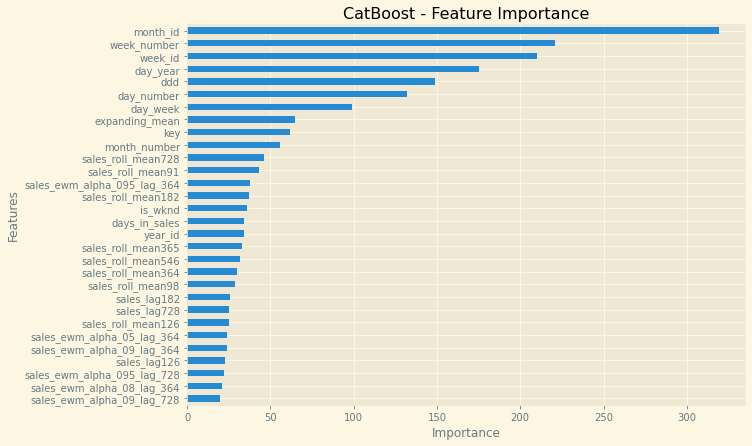

In [72]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [74]:
import datetime

preds_test = model.predict(x_test)
preds_test = pd.DataFrame(preds_test)
preds_test.columns = ['pred']

preds_test = x_test[['key','day_id']].reset_index(drop=True).merge(preds_test, left_index=True, right_index=True, how = 'left')
preds_test = preds_test.merge(y_test.reset_index(drop=True), left_index=True, right_index=True, how = 'left')

preds_test['day_id'] = pd.to_datetime(df['day_id'])

preds_test.head()

key     day_id         pred  y_interp3
0   4 2019-06-24   612.038823      608.0
1   1 2019-06-25  1607.367532     1626.0
2   5 2019-06-26   598.571966      550.0
3   2 2019-06-27   173.709333       91.0
4   2 2019-06-28   442.398856      378.0

In [214]:
# ИНОЕ + STANDARD SCALER
#preds_test_inverse = scaler.inverse_transform(preds_test['pred'])
#preds_test_inverse = pd.DataFrame(preds_test_inverse, columns = ['pred'])
#preds_test_inverse

In [215]:
# ИНОЕ + STANDARD SCALER
#preds_test_inverse = scaler.inverse_transform(preds_test['pred'])
#preds_test_inverse = pd.DataFrame(preds_test_inverse, columns = ['pred'])

#preds_test = pd.concat([x_test[['key','day_id']].reset_index(drop=True), preds_test_inverse], axis = 1)
#preds_test['day_id'] = pd.to_datetime(preds_test.day_id, format='%Y-%m-%d')

#fact = df[['key','day_id','y_interp3']]
#preds_test = pd.merge(preds_test, fact, how='left', left_on=['key','day_id'] , right_on = ['key','day_id'])

In [71]:
#preds_test = model.predict(x_test)
#preds_test = pd.DataFrame(preds_test)
#preds_test.columns = ['pred']
#preds_test_inverse = scaler.inverse_transform(preds_test['pred'])
#preds_test_inverse = pd.DataFrame(preds_test_inverse, columns = ['pred'])

#preds_test = pd.concat([x_test[['key','day_id','y_interp3']].reset_index(drop=True), preds_test_inverse], axis = 1)
#preds_test['day_id'] = pd.to_datetime(preds_test.day_id, format='%Y-%m-%d')

#preds_test

In [72]:
###preds_test = model.predict(x_test)
###preds_test = pd.DataFrame(preds_test)
###preds_test.columns = ['pred']
###preds_test_inverse = scaler.inverse_transform(preds_test['pred'])
###preds_test_inverse = pd.DataFrame(preds_test_inverse, columns = ['pred'])

               #preds_test = pd.concat([x_test[['key','day_id']].reset_index(drop=True), preds_test], axis = 1)
               #y_test_inverse = 

###preds_test = pd.concat([x_test[['key','day_id']].reset_index(drop=True), preds_test_inverse], axis = 1)

###preds_test['day_id'] = pd.to_datetime(preds_test.day_id, format='%Y-%m-%d')


#timeseries_df.isnull().value_counts()

###preds_test = pd.merge(preds_test, df_fact, how='left', left_on=['key','day_id'] , right_on = ['key','day_id'])
#preds_test['key'] = pd.Series(preds_test['key']).str.replace('.0', '').astype(int)
###preds_test

In [75]:
rmse = mean_squared_error(preds_test['y_interp3'], preds_test['pred'], squared=False)
mape = mean_absolute_percentage_error(preds_test['y_interp3'], preds_test['pred'])
wape = (preds_test['y_interp3'] - preds_test['pred']).abs().sum() / preds_test['y_interp3'].sum()

print(rmse)
print(mape)
print(wape)

65.18635906948118
0.08267417641925814
0.06615589833669579


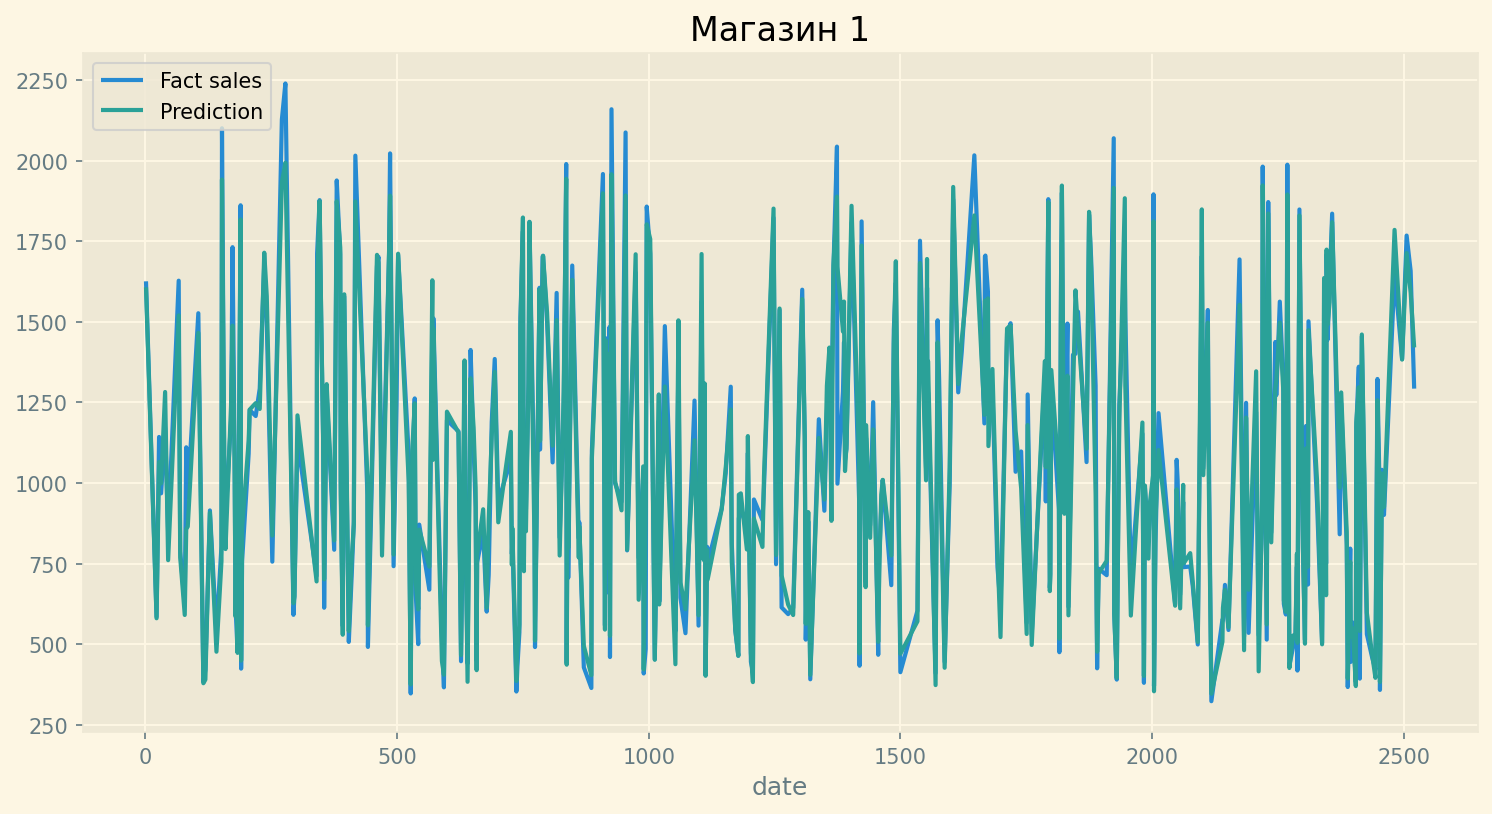

In [127]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==1')['y_interp3'].plot(label = 'Fact sales')
preds_test.query('key==1')['pred'].plot(label = 'Prediction')

plt.title('Магазин 1')
plt.xlabel('date')
plt.legend(loc='upper left')

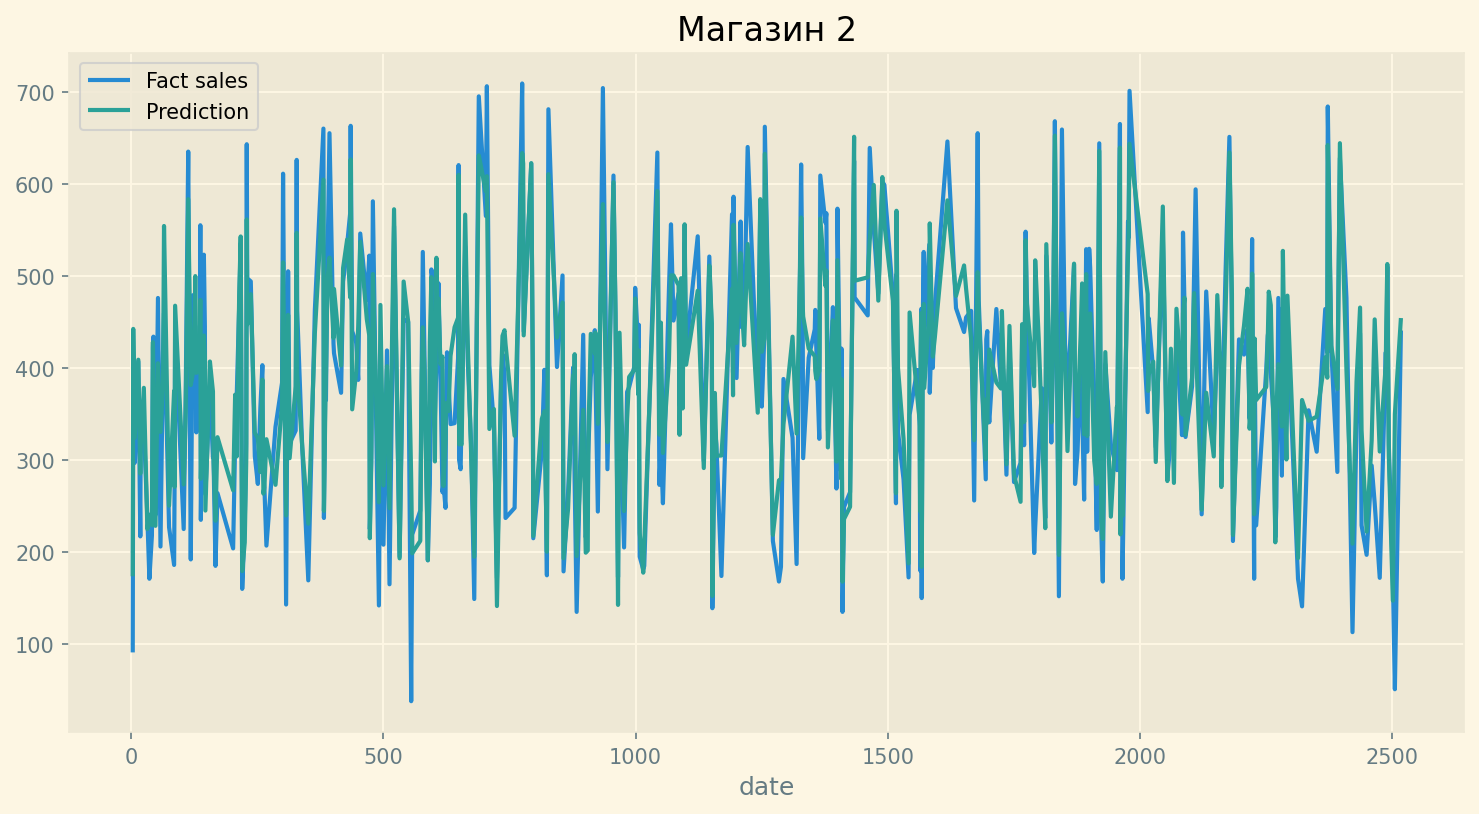

In [126]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==2')['y_interp3'].plot(label = 'Fact sales')
preds_test.query('key==2')['pred'].plot(label = 'Prediction')

plt.title('Магазин 2')
plt.xlabel('date')
plt.legend(loc='upper left')

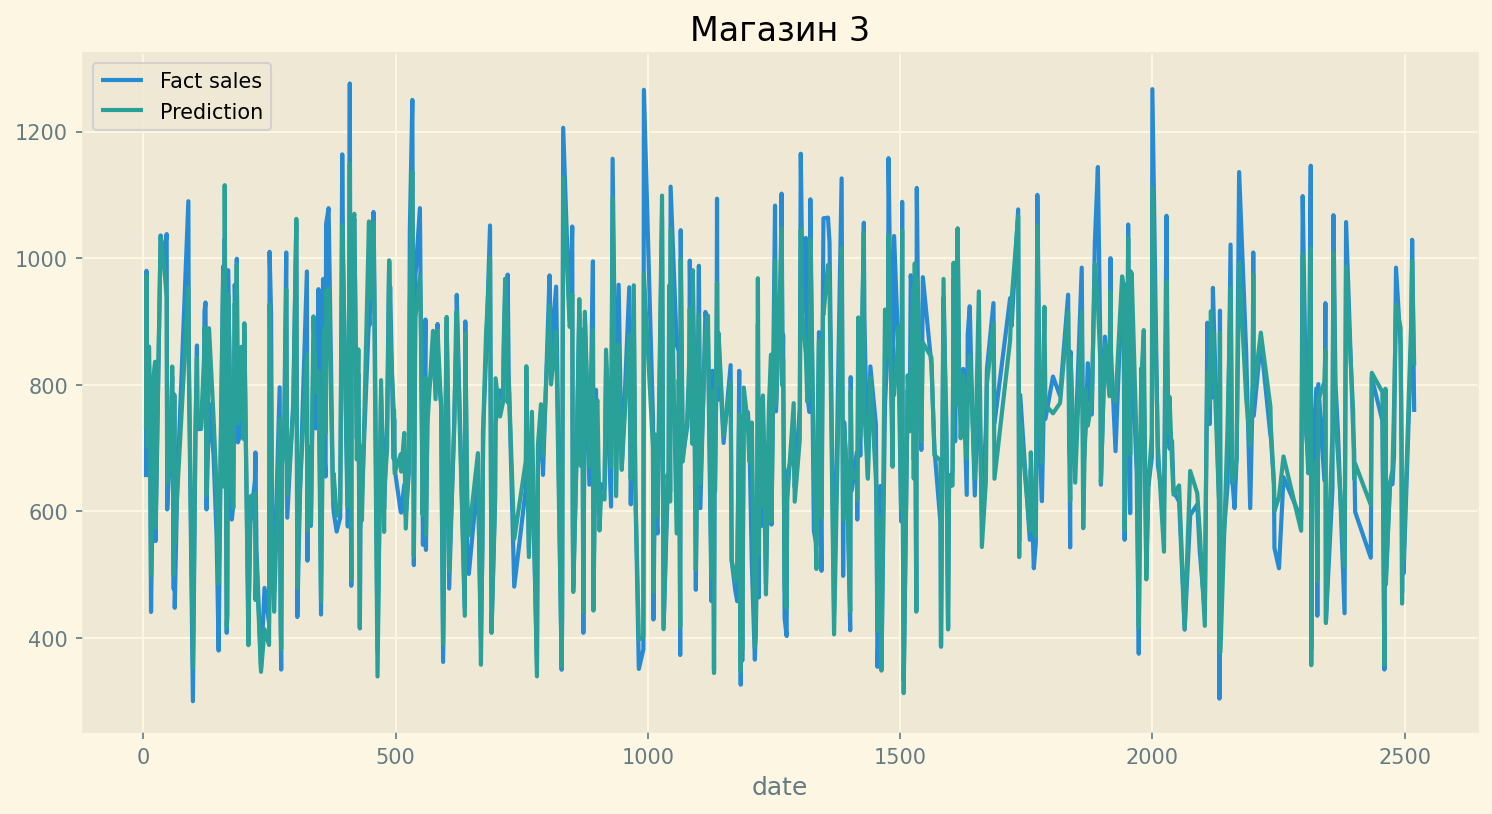

In [125]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==3')['y_interp3'].plot(label = 'Fact sales')
preds_test.query('key==3')['pred'].plot(label = 'Prediction')

plt.title('Магазин 3')
plt.xlabel('date')
plt.legend(loc='upper left')

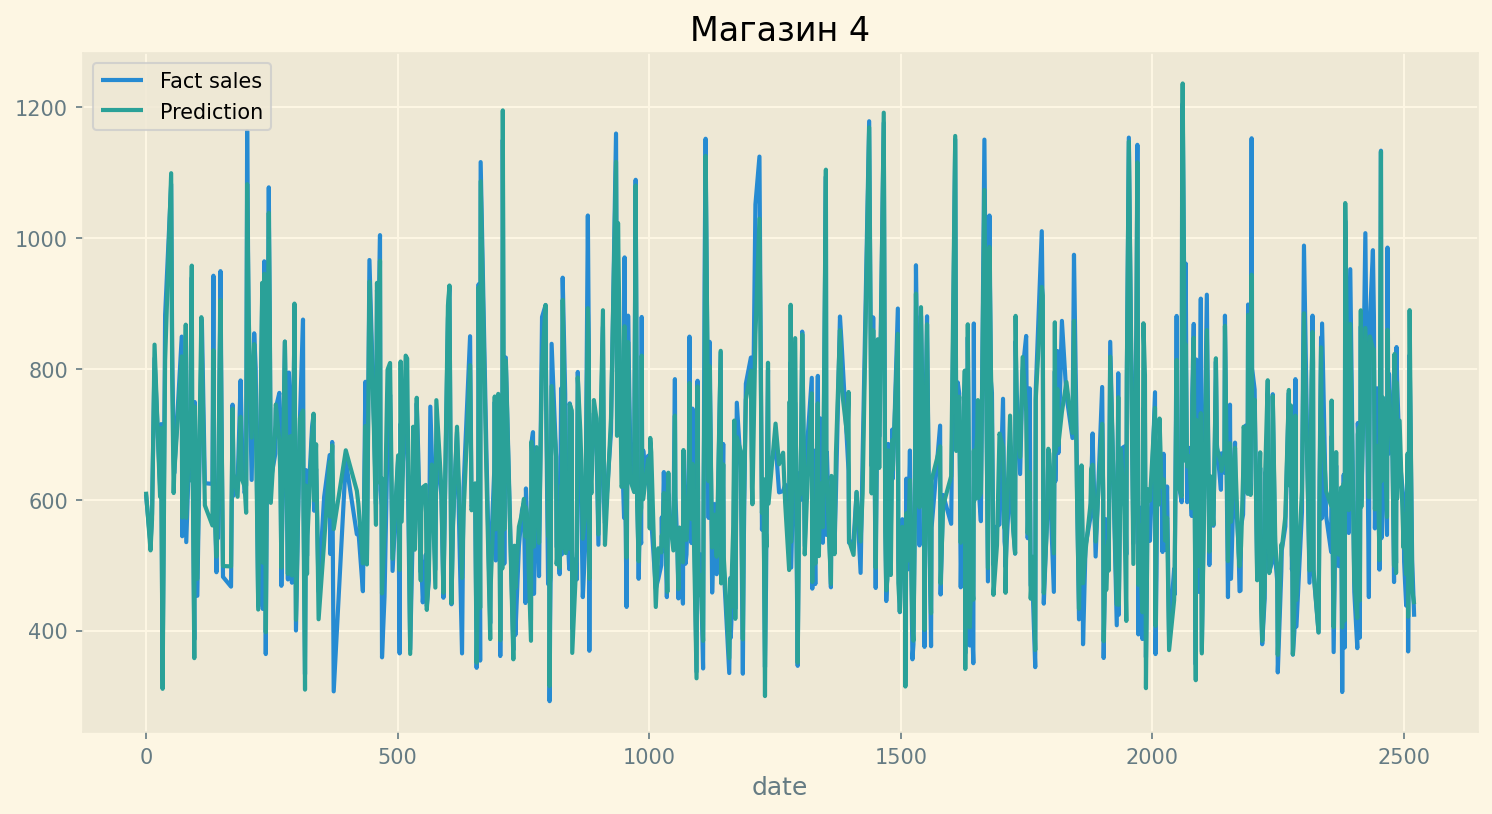

In [124]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==4')['y_interp3'].plot(label = 'Fact sales')
preds_test.query('key==4')['pred'].plot(label = 'Prediction')

plt.title('Магазин 4')
plt.xlabel('date')
plt.legend(loc='upper left')

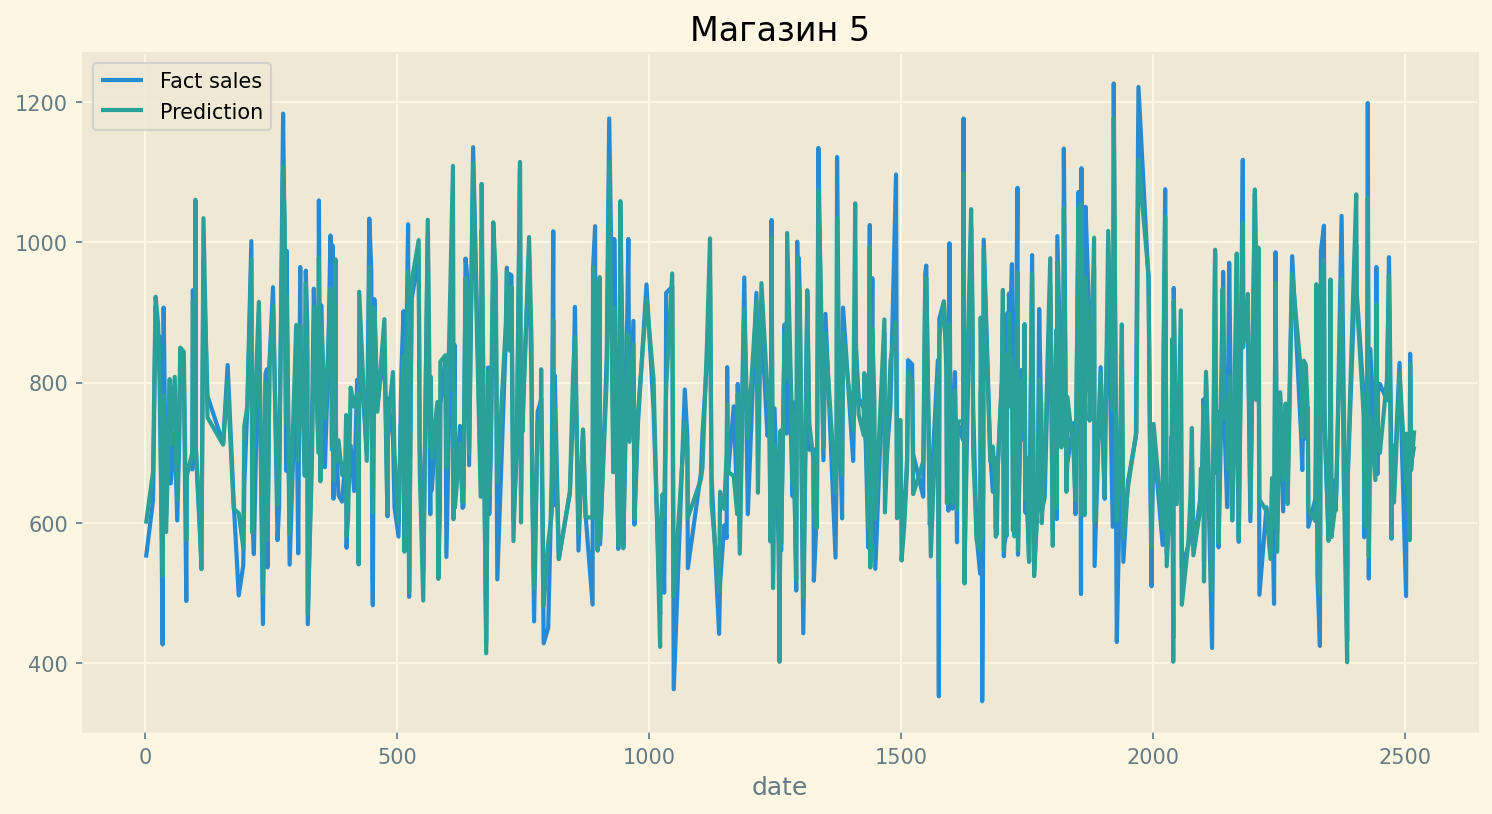

In [123]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==5')['y_interp3'].plot(label = 'Fact sales')
preds_test.query('key==5')['pred'].plot(label = 'Prediction')

plt.title('Магазин 5')
plt.xlabel('date')
plt.legend(loc='upper left')

# FINAL MODEL

In [81]:
X_train = df_train_test.drop(columns=['y','lower_y','upper_y','y_interp3'])  #,'y_sc'
Y_train = df_train_test['y_interp3']

In [82]:
import sklearn.datasets, sklearn.model_selection

LGBMR = LGBMRegressor(
    verbosity = -1,
    boosting_type = 'gbdt',
    #linear_tree = True,
    objective = 'regression',
    categorical_feature = categories,
    n_estimators = 500,
    learning_rate = 0.09836750613244324,
    num_leaves = 1182,
    max_depth = 4,
    min_data_in_leaf = 700,
    lambda_l1 = 0,
    lambda_l2 = 95,
    min_gain_to_split = 0.15232755581115676,
    bagging_fraction = 0.9,
    bagging_freq = 1,
    feature_fraction = 0.7,
    random_state = 78,
    extra_trees = False
)

preds_sub = np.zeros(df_submission.shape[0])

#preds = np.zeros(y_val.shape[0]+1)
cv_scores = np.empty(10)
cv = KFold(n_splits=10, shuffle=True, random_state=78)

for idx, (trn_idx, test_idx) in enumerate(cv.split(X_train, Y_train)):
    X_tr,X_val = X_train.iloc[trn_idx], X_train.iloc[test_idx]
    y_tr,y_val = Y_train.iloc[trn_idx], Y_train.iloc[test_idx]
    final_model = LGBMR
    final_model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val,y_val)],
        eval_metric='rmse',
        early_stopping_rounds=1,
    )
    preds = model.predict(X_val)
    # Сохраняем в массив результаты проверки
    cv_scores[idx] = mean_squared_error(y_val, preds.reshape(-1,1), squared=False)
    #LGBMR.plot_metric(model)
    
np.mean(cv_scores)


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.15232755581115676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.15232755581115676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's rmse: 270.126	valid_0's l2: 72968.2
[2]	valid_0's rmse: 255.472	valid_0's l2: 65265.7
[3]	valid_0's rmse: 242.72	valid_0's l2: 58912.8
[4]	valid_0's rmse: 2

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.15232755581115676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.15232755581115676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's rmse: 279.46	valid_0's l2: 78098.1
[2]	valid_0's rmse: 265.135	valid_0's l2: 70296.6
[3]	valid_0's rmse: 252.546	valid_0's l2: 63779.5
[4]	valid_0's rmse: 2

[3]	valid_0's rmse: 271.204	valid_0's l2: 73551.7
[4]	valid_0's rmse: 259.622	valid_0's l2: 67403.6
[5]	valid_0's rmse: 249.283	valid_0's l2: 62142.2
[6]	valid_0's rmse: 241.12	valid_0's l2: 58139
[7]	valid_0's rmse: 232.688	valid_0's l2: 54143.7
[8]	valid_0's rmse: 225.65	valid_0's l2: 50918.1
[9]	valid_0's rmse: 219.018	valid_0's l2: 47969
[10]	valid_0's rmse: 212.691	valid_0's l2: 45237.4
[11]	valid_0's rmse: 207.281	valid_0's l2: 42965.6
[12]	valid_0's rmse: 202.8	valid_0's l2: 41127.7
[13]	valid_0's rmse: 198.477	valid_0's l2: 39393.3
[14]	valid_0's rmse: 193.963	valid_0's l2: 37621.7
[15]	valid_0's rmse: 190.072	valid_0's l2: 36127.3
[16]	valid_0's rmse: 186.758	valid_0's l2: 34878.7
[17]	valid_0's rmse: 183.435	valid_0's l2: 33648.6
[18]	valid_0's rmse: 180.829	valid_0's l2: 32699.3
[19]	valid_0's rmse: 177.983	valid_0's l2: 31678
[20]	valid_0's rmse: 175.4	valid_0's l2: 30765
[21]	valid_0's rmse: 172.764	valid_0's l2: 29847.4
[22]	valid_0's rmse: 170.476	valid_0's l2: 29062.1
[

[182]	valid_0's rmse: 110.786	valid_0's l2: 12273.6
[183]	valid_0's rmse: 110.637	valid_0's l2: 12240.5
[184]	valid_0's rmse: 110.527	valid_0's l2: 12216.1
[185]	valid_0's rmse: 110.279	valid_0's l2: 12161.4
[186]	valid_0's rmse: 110.205	valid_0's l2: 12145.1
[187]	valid_0's rmse: 110.127	valid_0's l2: 12127.9
[188]	valid_0's rmse: 110.094	valid_0's l2: 12120.7
[189]	valid_0's rmse: 110.059	valid_0's l2: 12113
[190]	valid_0's rmse: 110.01	valid_0's l2: 12102.2
[191]	valid_0's rmse: 109.933	valid_0's l2: 12085.2
[192]	valid_0's rmse: 109.791	valid_0's l2: 12054
[193]	valid_0's rmse: 109.558	valid_0's l2: 12003
[194]	valid_0's rmse: 109.47	valid_0's l2: 11983.7
[195]	valid_0's rmse: 109.409	valid_0's l2: 11970.4
[196]	valid_0's rmse: 109.326	valid_0's l2: 11952.2
[197]	valid_0's rmse: 109.344	valid_0's l2: 11956
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.15232755581115676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.15232755581115676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's rmse: 302.11	valid_0's l2: 91270.4
[2]	valid_0's rmse: 286.353	valid_0's l2: 81997.8
[3]	valid_0's rmse: 272.567	valid_0's l2: 74292.8
[4]	valid_0's rmse: 2

[149]	valid_0's rmse: 101.115	valid_0's l2: 10224.3
[150]	valid_0's rmse: 101.051	valid_0's l2: 10211.3
[151]	valid_0's rmse: 100.894	valid_0's l2: 10179.5
[152]	valid_0's rmse: 100.778	valid_0's l2: 10156.2
[153]	valid_0's rmse: 100.476	valid_0's l2: 10095.4
[154]	valid_0's rmse: 100.201	valid_0's l2: 10040.2
[155]	valid_0's rmse: 100.137	valid_0's l2: 10027.4
[156]	valid_0's rmse: 100.066	valid_0's l2: 10013.2
[157]	valid_0's rmse: 99.9597	valid_0's l2: 9991.93
[158]	valid_0's rmse: 99.8663	valid_0's l2: 9973.29
[159]	valid_0's rmse: 99.5618	valid_0's l2: 9912.55
[160]	valid_0's rmse: 99.5212	valid_0's l2: 9904.46
[161]	valid_0's rmse: 99.4305	valid_0's l2: 9886.43
[162]	valid_0's rmse: 99.3616	valid_0's l2: 9872.72
[163]	valid_0's rmse: 99.2646	valid_0's l2: 9853.47
[164]	valid_0's rmse: 99.0458	valid_0's l2: 9810.08
[165]	valid_0's rmse: 98.9009	valid_0's l2: 9781.4
[166]	valid_0's rmse: 98.7731	valid_0's l2: 9756.13
[167]	valid_0's rmse: 98.711	valid_0's l2: 9743.87
[168]	valid_0'

[118]	valid_0's rmse: 115.183	valid_0's l2: 13267.1
[119]	valid_0's rmse: 115.062	valid_0's l2: 13239.2
[120]	valid_0's rmse: 115.046	valid_0's l2: 13235.5
[121]	valid_0's rmse: 114.922	valid_0's l2: 13207.1
[122]	valid_0's rmse: 114.493	valid_0's l2: 13108.7
[123]	valid_0's rmse: 114.323	valid_0's l2: 13069.8
[124]	valid_0's rmse: 113.978	valid_0's l2: 12990.9
[125]	valid_0's rmse: 113.831	valid_0's l2: 12957.5
[126]	valid_0's rmse: 113.584	valid_0's l2: 12901.3
[127]	valid_0's rmse: 113.439	valid_0's l2: 12868.4
[128]	valid_0's rmse: 113.219	valid_0's l2: 12818.5
[129]	valid_0's rmse: 113.089	valid_0's l2: 12789.2
[130]	valid_0's rmse: 112.987	valid_0's l2: 12766
[131]	valid_0's rmse: 112.987	valid_0's l2: 12766.1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_g

[153]	valid_0's rmse: 102.348	valid_0's l2: 10475.1
[154]	valid_0's rmse: 102.234	valid_0's l2: 10451.9
[155]	valid_0's rmse: 102.225	valid_0's l2: 10449.9
[156]	valid_0's rmse: 102.193	valid_0's l2: 10443.3
[157]	valid_0's rmse: 102.188	valid_0's l2: 10442.4
[158]	valid_0's rmse: 102.189	valid_0's l2: 10442.6
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.15232755581115676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.15232755581115676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ign

[55]	valid_0's rmse: 123.968	valid_0's l2: 15368
[56]	valid_0's rmse: 123.76	valid_0's l2: 15316.6
[57]	valid_0's rmse: 123.626	valid_0's l2: 15283.3
[58]	valid_0's rmse: 123.278	valid_0's l2: 15197.4
[59]	valid_0's rmse: 122.851	valid_0's l2: 15092.4
[60]	valid_0's rmse: 122.637	valid_0's l2: 15039.8
[61]	valid_0's rmse: 122.337	valid_0's l2: 14966.3
[62]	valid_0's rmse: 121.646	valid_0's l2: 14797.7
[63]	valid_0's rmse: 121.453	valid_0's l2: 14750.7
[64]	valid_0's rmse: 120.857	valid_0's l2: 14606.5
[65]	valid_0's rmse: 120.568	valid_0's l2: 14536.6
[66]	valid_0's rmse: 120.199	valid_0's l2: 14447.7
[67]	valid_0's rmse: 119.891	valid_0's l2: 14373.8
[68]	valid_0's rmse: 119.413	valid_0's l2: 14259.5
[69]	valid_0's rmse: 119.055	valid_0's l2: 14174.1
[70]	valid_0's rmse: 118.836	valid_0's l2: 14122
[71]	valid_0's rmse: 118.654	valid_0's l2: 14078.7
[72]	valid_0's rmse: 118.161	valid_0's l2: 13961.9
[73]	valid_0's rmse: 118.071	valid_0's l2: 13940.7
[74]	valid_0's rmse: 117.687	valid_0

[143]	valid_0's rmse: 102.255	valid_0's l2: 10456.1
[144]	valid_0's rmse: 102.122	valid_0's l2: 10428.9
[145]	valid_0's rmse: 102.065	valid_0's l2: 10417.3
[146]	valid_0's rmse: 102.017	valid_0's l2: 10407.4
[147]	valid_0's rmse: 101.743	valid_0's l2: 10351.7
[148]	valid_0's rmse: 101.704	valid_0's l2: 10343.7
[149]	valid_0's rmse: 101.476	valid_0's l2: 10297.4
[150]	valid_0's rmse: 101.285	valid_0's l2: 10258.6
[151]	valid_0's rmse: 101.134	valid_0's l2: 10228
[152]	valid_0's rmse: 101.046	valid_0's l2: 10210.3
[153]	valid_0's rmse: 100.844	valid_0's l2: 10169.6
[154]	valid_0's rmse: 100.664	valid_0's l2: 10133.2
[155]	valid_0's rmse: 100.44	valid_0's l2: 10088.3
[156]	valid_0's rmse: 100.39	valid_0's l2: 10078.2
[157]	valid_0's rmse: 100.195	valid_0's l2: 10039.1
[158]	valid_0's rmse: 100.131	valid_0's l2: 10026.2
[159]	valid_0's rmse: 100.036	valid_0's l2: 10007.2
[160]	valid_0's rmse: 99.7597	valid_0's l2: 9952
[161]	valid_0's rmse: 99.5515	valid_0's l2: 9910.5
[162]	valid_0's rmse

In [140]:
preds_sub = final_model.predict(df_submission)
preds_sub = pd.DataFrame(preds_sub, columns = ['pred_final'])
submission = pd.concat([df_submission[['day_id','key']].reset_index(drop=True), preds_sub], axis = 1)
submission['day_id'] = pd.to_datetime(submission['day_id'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')))
submission.head()

day_id key   pred_final
0 2023-08-01   1  1501.938352
1 2023-08-02   1  1407.394199
2 2023-08-03   1  1414.054514
3 2023-08-04   1  1432.931490
4 2023-08-05   1  1442.691670

In [ ]:
#submission = submission.merge(Y_train.reset_index(drop=True), left_index=True, right_index=True, how = 'left')
#submission.set_index(['day_id'], inplace=True)

#submission
#rmse = mean_squared_error(submission['y_interp3'], submission['pred_final'], squared=False)
#mape = mean_absolute_percentage_error(submission['y_interp3'], submission['pred_final'])
#wape = (submission['y_interp3'] - submission['pred_final']).abs().sum() / submission['y_interp3'].sum()

#print(rmse)
#print(mape)
#print(wape)

In [277]:
#preds_sub = final_model.predict(df_submission)

#preds_sub_inverse = scaler.inverse_transform(preds_sub['pred_final'])
#preds_sub_inverse = pd.DataFrame(preds_sub_inverse, columns = ['pred_final'])
#preds_sub_inverse

In [169]:
# Создание тестового df для построения прогноза с 31.07.2023.

#df_submission['day_id'] = pd.to_datetime(df_submission.day_id, format='%Y-%m-%d')
#df_submission['ddd'] = df_submission['day_id'].dt.dayofyear
#df_submission['day_id'] = pd.to_datetime(df_submission['day_id']).dt.strftime('%Y%m%d').astype(int)
#df_submission['day_id'] = df_submission['day_id'].astype('category')

In [145]:
#df_submission[['day_id','key']].reset_index(drop=True)

In [127]:
#timeseries_df.to_excel(r"C:\Users\vadim.sokolov\Desktop\В\test5\!.timeseries_df.xlsx")

In [118]:
####preds_sub = pd.DataFrame(preds_sub)
####preds_sub.columns = ['pred']
# preds_sub_inverse = scaler.inverse_transform(preds_sub['pred'])
# preds_sub_inverse = pd.DataFrame(preds_sub_inverse, columns = ['pred'])

####submission = pd.concat([df_submission[['day_id','key']].reset_index(drop=True), preds_sub], axis = 1)
#submission['key'] = pd.Series(submission['key']).str.replace('.0', '').astype(int)
####submission.head()

In [88]:
submission.to_excel(r'C:\Users\vadim.sokolov\Desktop\В\test5\submission.xlsx')

In [ ]:
df_train_test['day_id'] = pd.to_datetime(df_train_test['day_id'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')))

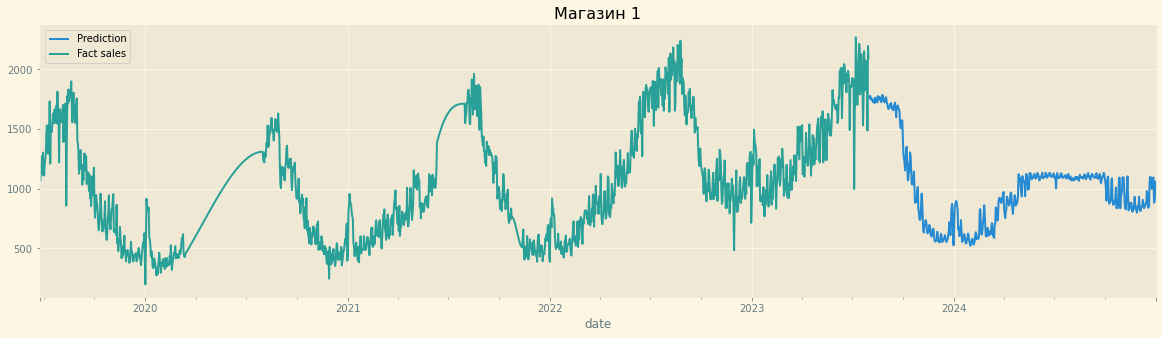

In [122]:
fig, ax = plt.subplots(figsize=(20,5))

submission.query('key==1').plot(ax=ax, label = 'Prediction', x='day_id', y='pred_final')
df_train_test.query('key==1').plot(ax=ax, label = 'Fact sales', x='day_id', y='y_interp3')

plt.title('Магазин 1')
plt.xlabel('date')
plt.legend(loc='upper left')

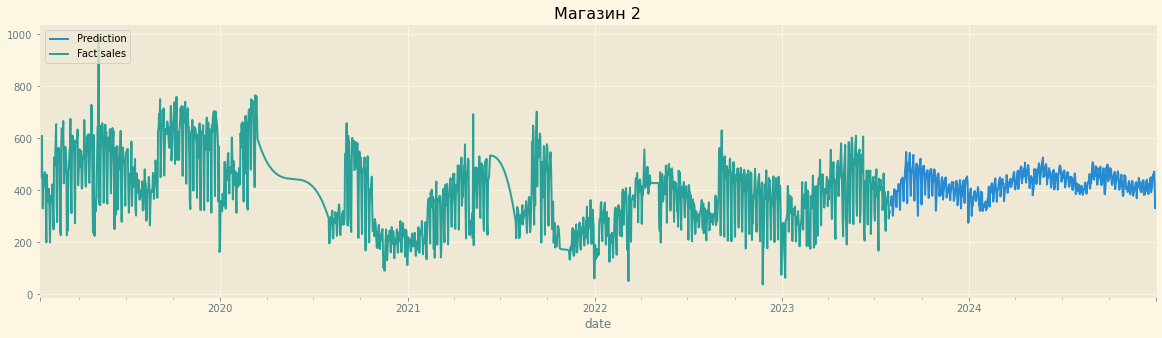

In [121]:
fig, ax = plt.subplots(figsize=(20,5))

submission.query('key==2').plot(ax=ax, label = 'Prediction', x='day_id', y='pred_final')
df_train_test.query('key==2').plot(ax=ax, label = 'Fact sales', x='day_id', y='y_interp3')

plt.title('Магазин 2')
plt.xlabel('date')
plt.legend(loc='upper left')

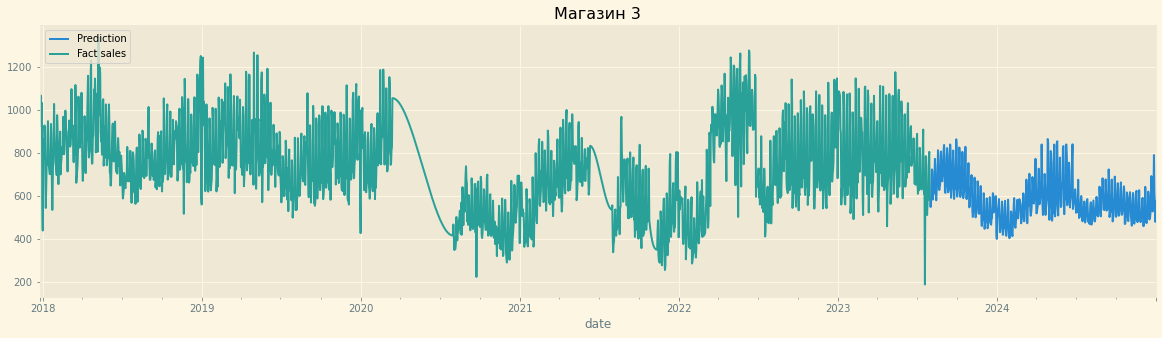

In [120]:
fig, ax = plt.subplots(figsize=(20,5))

submission.query('key==3').plot(ax=ax, label = 'Prediction', x='day_id', y='pred_final')
df_train_test.query('key==3').plot(ax=ax, label = 'Fact sales', x='day_id', y='y_interp3')

plt.title('Магазин 3')
plt.xlabel('date')
plt.legend(loc='upper left')

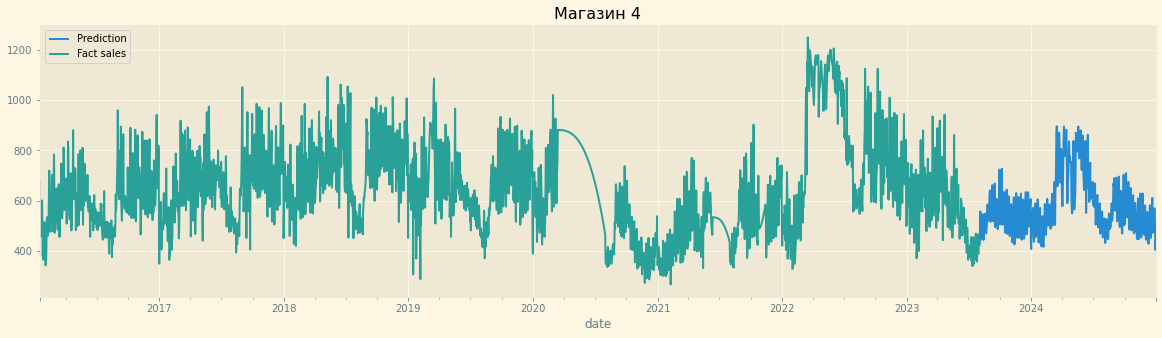

In [119]:
fig, ax = plt.subplots(figsize=(20,5))

submission.query('key==4').plot(ax=ax, label = 'Prediction', x='day_id', y='pred_final')
df_train_test.query('key==4').plot(ax=ax, label = 'Fact sales', x='day_id', y='y_interp3')

plt.title('Магазин 4')
plt.xlabel('date')
plt.legend(loc='upper left')

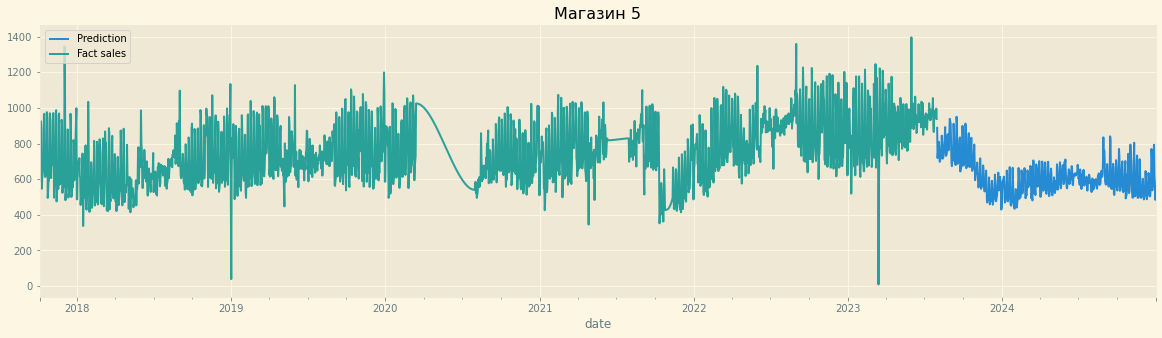

In [118]:
fig, ax = plt.subplots(figsize=(20,5))

submission.query('key==5').plot(ax=ax, label = 'Prediction', x='day_id', y='pred_final')
df_train_test.query('key==5').plot(ax=ax, label = 'Fact sales', x='day_id', y='y_interp3')

plt.title('Магазин 5')
plt.xlabel('date')
plt.legend(loc='upper left')

In [139]:
list(df_train_test.columns)

['key',
 'y',
 'ddd',
 'days_in_sales',
 'lower_y',
 'upper_y',
 'y_interp3',
 'day_id',
 'week_id',
 'month_id',
 'year_id',
 'day_year',
 'day_week',
 'day_number',
 'week_number',
 'month_number',
 'quarter_number',
 'is_holiday',
 'is_warm',
 'is_black_friday',
 'is_wknd',
 'is_month_start',
 'is_month_end',
 'sales_lag91',
 'sales_lag98',
 'sales_lag105',
 'sales_lag112',
 'sales_lag119',
 'sales_lag126',
 'sales_lag182',
 'sales_lag364',
 'sales_lag365',
 'sales_lag546',
 'sales_lag728',
 'sales_roll_mean91',
 'sales_roll_mean98',
 'sales_roll_mean105',
 'sales_roll_mean112',
 'sales_roll_mean119',
 'sales_roll_mean126',
 'sales_roll_mean182',
 'sales_roll_mean364',
 'sales_roll_mean365',
 'sales_roll_mean546',
 'sales_roll_mean728',
 'sales_ewm_alpha_095_lag_91',
 'sales_ewm_alpha_095_lag_98',
 'sales_ewm_alpha_095_lag_105',
 'sales_ewm_alpha_095_lag_112',
 'sales_ewm_alpha_095_lag_180',
 'sales_ewm_alpha_095_lag_270',
 'sales_ewm_alpha_095_lag_364',
 'sales_ewm_alpha_095_lag_36

In [ ]:
df_hw = df[['key','day_id','y_sc']]
df_hw['y_sc'].fillna(0,inplace=True)
df_hw

df_hw[-2595:]


import statsmodels as sm
sm.tsa.holtwinters.ExponentialSmoothing

df_hw = df[['key','day_id','y_sc']]

df_hw['day_id'] = pd.to_datetime(df['day_id']).dt.strftime('%Y%m%d').astype(int)
df_hw = df_hw.pivot(values='y_sc', index=['key'], columns='day_id')
#df_hw = df_hw.astype(float)
d_cols = df_hw.select_dtypes([np.int64]).columns   #[np.int64,np.float64]

train_dataset = df_hw[d_cols[:-1522]].fillna(0)

model_expo1 = sm.tsa.holtwinters.ExponentialSmoothing(df_hw[-2595:],trend = 'add',
                                                      seasonal = 'add', seasonal_periods=52)
model_expo2 = sm.tsa.holtwinters.ExponentialSmoothing(df_hw[-2595:],trend = 'mul',
                                                      seasonal = 'add', seasonal_periods=52)
model_expo3 = sm.tsa.holtwinters.ExponentialSmoothing(df_hw[-2595:],trend = 'add',
                                                      seasonal = 'mul', seasonal_periods=52)
model_expo4 = sm.tsa.holtwinters.ExponentialSmoothing(df_hw[-2595:],trend = 'mul',
                                                      seasonal = 'mul', seasonal_periods=52)

predictions_model_1 = []
predictions_model_2 = []
predictions_model_3 = []
predictions_model_4 = []

for row in tqdm(train_dataset[train_dataset.columns].values):
    results_1 = model_expo1.fit()
    results_2 = model_expo2.fit()
    results_3 = model_expo3.fit()
    results_4 = model_expo4.fit()
    HoltWinters1 = model_expo1.fit().predict(0, len(df_hw)-1)
    HoltWinters2 = model_expo2.fit().predict(0, len(df_hw)-1)
    HoltWinters3 = model_expo3.fit().predict(0, len(df_hw)-1)
    HoltWinters4 = model_expo4.fit().predict(0, len(df_hw)-1)

results_1.summary()
results_2.summary()
results_3.summary()
results_4.summary()

HoltWinters_MAPE1 = mean_absolute_percentage_error(HoltWinters1, df[:-522])*100
HoltWinters_MAPE2 = mean_absolute_percentage_error(HoltWinters2, df[:-522])*100
HoltWinters_MAPE3 = mean_absolute_percentage_error(HoltWinters3, df[:-522])*100
HoltWinters_MAPE4 = mean_absolute_percentage_error(HoltWinters4, df[:-522])*100

In [ ]:
# ISOLATION FOREST
AAfrom sklearn.ensemble import IsolationForest

outliers_fraction = float(.15)
model =  IsolationForest(n_estimators=200, 
                         max_samples = 5, 
                         bootstrap = True, 
                         random_state = 47,
                         contamination=outliers_fraction)

segments = set(ts_df['key'])
ts_df_2 = pd.DataFrame([])
for s in segments:
    df = ts_df[ts_df['key'] == s]
    
    model.fit(df)
    df['anomaly'] = model.predict(df)
       
    ts_df_2 = ts_df_2.append(df)

# визуализация магазинов с аномальными выбросами.
fig, ax = plt.subplots(figsize=(10,6))
data_scale = ts_df_2.query('key==5')[['y','anomaly']]
a = data_scale.loc[data_scale['anomaly'] == -1, ['y']] #anomaly
ax.plot(data_scale.index, data_scale['y'], color='black', label = 'Normal')
ax.scatter(a.index, a['y'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

In [ ]:
afrom statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

df_trend = df.loc[:,['day_id','key','y_sc']]  #df.loc[:, ['col2', 'col4']]
y_1 = df_trend.pivot(values='y_sc', index=['day_id'], columns='key').fillna(0).copy()
y_1.reset_index(inplace=True)
y_1.set_index('day_id', inplace=True)
y_1.T.reset_index(drop=True).T

# df_hw = df_hw
dp = DeterministicProcess(index = y_1.index,  # dates from training data
                          constant=True,      # intercept
                          order=2,            # quadratic end
                          drop=True)          # drop terms to avoid collinearity
X = dp.in_sample()   # features for the training data

idx_train, idx_test = train_test_split(y.index, test_size=len(y[y.index > '2023-07-31']), shuffle=False)
X_train, X_test = X.loc[idx_train,:], X.loc[idx_test,:]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

model = LinearRegression(fit_intercept=False)
model.fit(X_train,y_train)

y_fit = pd.DataFrame(model.predict(X_train), index = y_train.index, columns = y_train.columns)
y_pred = pd.DataFrame(model.predict(X_test), index = y_test.index, columns = y_test.columns)


#print(x_train.shape, y_train.shape)
#print(x_test.shape, y_test.shape)
##############################################################################
#Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True)

for ax in axs: ax.legend([])
_ = plt.suptitle('Trends')

##############################################################################
#y_fit = pd.DataFrame(y_fit.stack().squeeze().reset_index())
#y_pred = pd.DataFrame(y_pred.stack().squeeze().reset_index())

#y_resid = y_train - y_fit

##############################################################################

#df_trend = df.loc[:,['day_id','key','y_sc']]  #df.loc[:, ['col2', 'col4']]
#y_1 = df_trend.pivot(values='y_sc', index=['day_id'], columns='key').fillna(0).copy()
#y_1.reset_index(inplace=True)
#y_1.set_index('day_id', inplace=True)
#y_1.T.reset_index(drop=True).T

In [ ]:
# BEST LAG FEATURES
# https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/
#from sklearn.ensemble import RandomForestRegressor

def lag_features(df, lags):
    df = df.copy()
    for lag in lags:
        df[str(lag)] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(lag)) + random_noise(df)
    return df

df_lag_features = lag_features(df[['key','y_interp3']], [1,2,3,4,5,6,7,12,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119,126,182,364,546,728])
df_lag_features.drop('key', axis=1, inplace=True)
df_lag_features.fillna(0,inplace=True)
df_lag_features

# load data
#dataframe = df_lag_features
#array = dataframe.values
# split into input and output
#X = array[:,1:]
#y = array[:,0]
# fit random forest model
#model = RandomForestRegressor(n_estimators=500, random_state=1)
#model.fit(X, y)
# show importance scores
#print(model.feature_importances_)
# plot importance scores
#names = dataframe.columns.values[1:]
#ticks = [i for i in range(len(names))]
#plt.bar(ticks, model.feature_importances_)
#plt.xticks(ticks, names)
#plt.show()

In [ ]:
def create_ewm_feature(df, windows, alpha):
    for window in windows:
        df['sales_rolling_ewma' + str(window)] = df.groupby(['key']).y_interp3.transform(
            lambda x: x.shift(window).ewm(alpha = alpha).mean())
    return df
df = create_ewma_feature(df, windows, alpha)
df.fillna(0, inplace=True)

In [ ]:
# Тренд, лаги, пропорции продаж, скользящие средние/медианы/мин/макс/ст.откл. 
#df['sum_fact'] = df.groupby(['key'])['y_sc'].transform('sum').astype(np.float16) 
#df['proportion'] = df['y_sc'] / df['sum_fact']

# Trend
#df['day_avg_sold'] = df.groupby(['key','day_id'])['y_sc'].transform('mean').astype(np.float16)
# Total Average by SKU (Item Id + Store)
#df['avg_sold'] = df.groupby(['key'])['y_sc'].transform('mean').astype(np.float16)
# Selling Trend
#df['trend'] = (df['day_avg_sold'] - df['avg_sold']).astype(np.float16)

#for i in [1,2,3,4,5,6,7,14,21,28,35,42,49,56,63,70,84,98,112,126,140,154,168,182,196,210,224,238,252,266,280,294,
#          308,322,336,350,364,378,392,406,420,434,448,462,476,490,504,518]:
#    print('lag_period',i)
#    df['lag_'+str(i)] = df.groupby(['key'])['y_sc'].shift(i)

#for i in [1,2,3,4,5,6,7,14,21,28,35,42,49,56,63,70,84,98,112,126,140,154,168,182,196,210,224,238,252,266,280,294,
#          308,322,336,350,364,378,392,406,420,434,448,462,476,490,504,518]:
#    print('lag_period',i)
#    df['lag_'+str(i)] = df.groupby(['key'])['proportion'].shift(i)    

#for i in [1,2,3,4,5,6,7,14,21,28,35,42,49,56,63,70,84,98,112,126,140,154,168,182,196,210,224,238,252,266,280,294,
#          308,322,336,350,364,378,392,406,420,434,448,462,476,490,504,518]:
#    print('lag_period',i)
#    df['lag_'+str(i)] = df.groupby(['key'])['trend'].shift(i)    
////////////////////
# Drop Columns 
#df.drop(['sum_fact','proportion','day_avg_sold','avg_sold','trend'],axis=1,inplace=True)  

In [ ]:
# ИНОЕ ТЕСТИРОВАНИЕ 2
df['day_id'] = pd.to_datetime(df['day_id'])

df_train_test = df.loc[(pd.to_datetime(df.day_id, format='%Y-%m-%d') <= pd.to_datetime('2023-07-31', format='%Y-%m-%d')) & (df.year_id.astype(int) < 2023)].copy()
# 
#df_train_test = .copy(
df_submission = df.loc[df.year_id.astype(int) >= 2023].copy()

df_train_test['day_id'] = pd.to_datetime(df_train_test['day_id']).astype(np.int64)
df_submission['day_id'] = pd.to_datetime(df_submission['day_id']).astype(np.int64)
df_submission = df_submission.drop(columns=['y','lower_y','upper_y','y_interp3'])  # 'y_interp3','y_sc',

X = df_train_test.drop(columns=['y','lower_y','upper_y','y_interp3'])  #,'y_sc',
y = df_train_test['y_interp3']# 

In [ ]:
# Очистка временных рядов от выбросов.
# Проверка на наличие выбросов:

#for i in timeseries_df.select_dtypes(include=['float64']).columns:
#    max_thresold=timeseries_df[i].quantile(0.95)
#    min_thresold=timeseries_df[i].quantile(0.05)
#    train_no_outlier=timeseries_df[(timeseries_df[i] < max_thresold) & (timeseries_df[i] > min_thresold)].shape
#    print(" outlier in ",i,"is" ,int(((timeseries_df.shape[0]-train_no_outlier[0])/timeseries_df.shape[0])*100),"%")

#for i in timeseries_df.select_dtypes(include=['float64']).columns:
#    max_thresold=timeseries_df[i].quantile(0.95)
#    min_thresold=timeseries_df[i].quantile(0.05)
#    print (min_thresold)

for group,i in df.groupby(['key']):
    q1 = i['y'].quantile(0.95)
    q3 = i['y'].quantile(0.05)
    iqr = q3 - q1
    lower_tail = q1 - 1.5 * iqr
    upper_tail = q3 - 1.5 * iqr


for group,i in df.groupby(['key']):
    q1 = i['y'].quantile(0.95)
    q3 = i['y'].quantile(0.05)
    iqr = q3 - q1
    lower_tail = q1 - 1.5 * iqr
    upper_tail = q3 - 1.5 * iqr
    for i in df[['y']].iterrows():
        #i = i[1].astype(int).values
        if i[1].astype(int).values > upper_tail or i[1].astype(int).values < lower_tail:
            df_no_outlier = df[(df['y'] < upper_tail) & (df['y'] > lower_tail)]

for group,i in df.groupby(['key']):
    q1 = i['y'].quantile(0.95)
    q3 = i['y'].quantile(0.05)
    #iqr = q3 - q1
    #lower_tail = q1 - 1.5 * iqr
    #upper_tail = q3 - 1.5 * iqr
    for i in df.iterrows():
        df_no_outlier = df[(df['y'] < q1) & (df['y'] > q3)]
    
#for i in train.select_dtypes(include=['float16']).columns:
#    max_thresold=train[i].quantile(0.95)
#    min_thresold=train[i].quantile(0.05)
#    train_no_outlier=train[(train[i] < max_thresold) & (train[i] > min_thresold)].shape


id_group=df.groupby(['key'])

for group,i in df.groupby(['key']):
    q1 = i['y'].quantile(0.95)
    q3 = i['y'].quantile(0.05)
    iqr = q3 - q1
    lower_tail = q1 - 1.5 * iqr
    upper_tail = q3 - 1.5 * iqr
    for i in df[['y']].iterrows():
        if i[1].astype(int) > upper_tail or i[1].astype(int) < lower_tail:
            #print(df['y'])
        #if df['y'] > upper_tail: #or df['y'] < lower_tail:
            df['y'] = df['y'].replace(df['y'], np.mean(df['y']))

            
for group,i in df.groupby(['key']):
    q1 = i['y'].quantile(0.95)
    q3 = i['y'].quantile(0.05)
    iqr = q3 - q1
    lower_tail = q1 - 1.5 * iqr
    upper_tail = q3 - 1.5 * iqr
    print(q3)
    
#2662.5000000000005
#876.5999999999998
#1423.875
#1379.8749999999993
#1345.75
#674.1835063897763



df1 = df[['key','y']]
#df1 = df1.groupby(['key','day_id'])['y'].sum()
for i in df1:
    q1 = df1.groupby(['key'])['y'].sum().quantile(0.95)
    q3 = df1['y'].quantile(0.05)
    iqr = q3 - q1
    lower_tail = q1 - 1.5 * iqr
    upper_tail = q3 - 1.5 * iqr
    for d in b.iterrows():
        #if (d['y'] > upper_tail or d['y'] < lower_tail).all():
        #    print (d['y'])
        #    df1['y'] = df1['y'].replace(df1['y'], np.mean(df1['y']))
        print (d['y'])

            
    #train_no_outlier=df1[(df1['y'] < max_thresold) & (df1['y'] > min_thresold)].shape
    #print(" outlier in ",i,"is" ,int(((df['y'].shape[0]-train_no_outlier[0])/df['y'].shape[0])*100),"%")
    
#for i in df['y'].index:
#    max_thresold=df['y'].quantile(0.95)
#    min_thresold=df['y'].quantile(0.05)
#    df_no_outlier = df[(df['y'] < max_thresold) & (df['y'] > min_thresold)]
#    print(" outlier in ",i,"is" ,int(((df['y'].shape[0]-df_no_outlier[0])/df['y'].shape[0])*100),"%")

df1 = df[['key','day_id','y']].set_index('key')
#df1 = df1.groupby(['key','day_id'])['y'].sum()
for i in enumerate(df1):
    q1 = df1.groupby(['key'])['y'].quantile(0.95)
    q3 = df1.groupby(['key'])['y'].quantile(0.05)
    iqr = q3 - q1
    lower_tail = q1 - 1.5 * iqr
    upper_tail = q3 - 1.5 * iqr
    print (q3)
    if df1['y'] > upper_tail or df1['y'] < lower_tail:
        print (df1['y'])
        #    df1['y'] = df1['y'].replace(df1['y'], np.mean(df1['y']))